In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge
from scipy import stats
import random
from scipy.stats import sem

# Dataset

In [2]:
jerks_path = "Synthesised_Dataset/Appropriateness_Features/mean_jerk_values.csv"
XX_jerks = pd.read_csv(jerks_path) # With Spine joint and Name of "Cond/StudySeq"

accels_path = "Synthesised_Dataset/Appropriateness_Features/mean_acceleration_values.csv"
XX_accels = pd.read_csv(accels_path) # With Spine joint and Name of "Cond/StudySeq"

pairwise_path = "Synthesised_Dataset/Appropriateness_Features/mean_pairwise_joint_distances.csv"
XX_pairwise = pd.read_csv(pairwise_path) # With Spine joint and Name of "Cond/StudySeq"
XX_pairwise.drop(XX_pairwise.columns[range(1,15)], axis=1, inplace=True) # Without Spine Joint but with Name of "Cond/StudySeq"

rms_properties_path = "Synthesised_Dataset/Appropriateness_Features/RMS_Energy_properties.csv"
XX_rms_energy_properties = pd.read_csv(rms_properties_path, index_col = False) # With Name of StudySeq

rms_distance_path = "Synthesised_Dataset/Appropriateness_Features/RMS_Distance_scores_fd_scaled.csv"
XX_rms_distance_scores = pd.read_csv(rms_distance_path)
XX_rms_distance_scores.drop(XX_rms_distance_scores.columns[1], axis=1, inplace=True) # Dropping the Spine joint (always 0)

labels_path = "Synthesised_Dataset/Appropriateness_Labels/mean_opinion_scores.csv"
YY = pd.read_csv(labels_path) # # With Name of "Cond/StudySeq"

In [3]:
XY = XX_jerks.join(YY, lsuffix="_jerks", rsuffix="_YY")
XY = XY.join(XX_accels, rsuffix='_accels')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_accels'})
XY = XY.join(XX_pairwise, rsuffix='_pairwise')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_pairwise'})
XY = XY.join(XX_rms_distance_scores)
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_rms_distance_scores'})

In [4]:
# Join the RMS Energy Properties Features
XY = XY.rename(columns={'Unnamed: 0_jerks': 'StudySeq'})
XY['Cond'] = XY['StudySeq'].apply(lambda x: x[:x.index('/')])
XY['StudySeq'] = XY['StudySeq'].apply(lambda x: x[x.index('q')+1:]) # Remove info on Cond
XY = XY.join(XX_rms_energy_properties, rsuffix='_rms')
for i in range(1,int(XY.shape[0]/80)):
    XY.iloc[i*80:(i+1)*80,-5:] = XX_rms_energy_properties

In [5]:
# Drop the Names of "Cond/StudySeq" and remaining information relating to the "Spine" joint
# Also Drop the Index from rms_energy
XY.drop(['Unnamed: 0_YY','Unnamed: 0_accels', 'Unnamed: 0_pairwise', 'Spine', 'Spine_accels',
        'Unnamed: 0_rms_distance_scores', 'Unnamed: 0', 'StudySeq_rms'], axis=1, inplace=True)

rename_dict = dict(zip(XY.columns[1:15], XY.columns[1:15] + '_jerks'))
XY = XY.rename(columns=rename_dict)

# Jerk for 14 joints + Acceleration for 14 joints + 14 choose 2 pairwise distance + 14 RMS Energy Distance Scores + 3 RMS Energy Property Features + Label for MOS = 137
print(XY.shape)

(7200, 139)


In [6]:
cols = XY.columns.tolist()
cols.remove('Cond')
cols = ['Cond'] + cols
XY = XY[cols]


In [7]:
XY['StudySeq'] = pd.to_numeric(XY['StudySeq'])
XX = XY.drop(['Mean_Appropriateness_Score'], axis=1, inplace=False)
bad_features = ['LeftShoulder_vs_LeftArm', 'LeftArm_vs_LeftForeArm', 'LeftForeArm_vs_LeftHand',
                'RightShoulder_vs_RightArm', 'RightArm_vs_RightForeArm','RightForeArm_vs_RightHand']
XX.drop(bad_features, axis=1, inplace=True)
YY = XY[['Cond', 'StudySeq', 'Mean_Appropriateness_Score']]
XX.iloc[:,2:] = np.log(XX.iloc[:,2:])
print(XX.shape)
print(YY.shape)

(7200, 132)
(7200, 3)


198.63134441390545


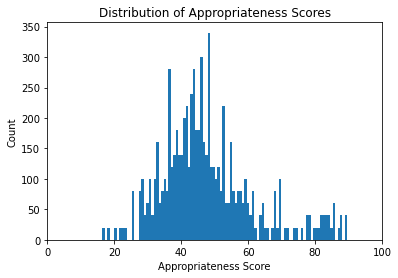

In [8]:
plt.hist(YY['Mean_Appropriateness_Score'], bins = 100)
plt.xlim(0,100)
plt.xlabel("Appropriateness Score")
plt.ylabel("Count")
plt.title("Distribution of Appropriateness Scores")
var = np.var(YY['Mean_Appropriateness_Score'])
print(var)

In [9]:
XX.describe()

,StudySeq,Spine1_jerks,Spine2_jerks,Spine3_jerks,LeftShoulder_jerks,LeftArm_jerks,LeftForearm_jerks,LeftHand_jerks,RightShoulder_jerks,RightArm_jerks,...,RightShoulder_RMS_Distance_Score,RightArm_RMS_Distance_Score,RightForeArm_RMS_Distance_Score,RightHand_RMS_Distance_Score,Neck_RMS_Distance_Score,Neck1_RMS_Distance_Score,Head_RMS_Distance_Score,min_RMS_Energy,max_RMS_Energy,mean_RMS_Energy
count,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,...,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000
mean,400.500000,7.238224,7.366150,7.502528,7.643845,7.818509,8.371011,8.832591,7.643845,7.818509,...,-0.861053,-0.739701,-0.739745,-0.405888,-0.859546,-0.875652,-0.864515,-3.696289,-0.866533,-1.614794
std,230.955966,0.700900,0.544234,0.469295,0.428828,0.392611,0.479328,0.461389,0.428828,0.392611,...,0.242335,0.294201,0.206041,0.223511,0.246200,0.254507,0.266081,0.797139,0.272385,0.289059
min,1.000000,3.655330,4.439885,4.900368,5.196570,5.435678,6.282438,6.804531,5.196570,5.435678,...,-4.605170,-4.605170,-4.605170,-4.605170,-4.605170,-4.605170,-4.605170,-5.366736,-1.395301,-2.128564
25%,200.750000,7.379390,7.453055,7.553634,7.668211,7.792639,8.063996,8.517175,7.668211,7.792639,...,-0.913916,-0.775950,-0.748576,-0.413352,-0.917868,-0.939943,-0.928811,-4.170783,-1.030628,-1.822282
50%,400.500000,7.420968,7.500836,7.606680,7.729511,7.864279,8.241831,8.749755,7.729511,7.864279,...,-0.854643,-0.719838,-0.732253,-0.399288,-0.851712,-0.866712,-0.853659,-3.590974,-0.886227,-1.608296
75%,600.250000,7.463648,7.556748,7.674101,7.799836,7.980365,8.621657,9.125945,7.799836,7.980365,...,-0.788465,-0.650370,-0.714421,-0.383054,-0.782840,-0.790458,-0.780005,-3.330635,-0.686539,-1.348266
max,800.000000,7.964174,7.989612,8.100524,8.316989,8.586239,9.852115,10.339779,8.316989,8.586239,...,0.009950,0.009950,0.009950,0.009950,0.009950,0.009950,0.009950,-2.109763,-0.139434,-1.058574


# Function Definitions

In [10]:
# studyseqs_to_keep should be a list of the studyseq indexes to keep (e.g. [1,2,3,4....,40] for the original unaugmented data)
def reduce_dataset_size(XX, YY, studyseqs_to_keep):
    reduced_XX = XX[XX['StudySeq'].isin(studyseqs_to_keep)]
    reduced_YY = YY[YY['StudySeq'].isin(studyseqs_to_keep)]
    return reduced_XX, reduced_YY

In [11]:
def split_by_cond(XX, YY, cond_to_split):
    reduced_XX = XX[XX['Cond'].isin([cond_to_split]) == False]
    reduced_YY = YY[YY['Cond'].isin([cond_to_split]) == False]
    cond_XX = XX[XX['Cond'].isin([cond_to_split])]
    cond_YY = YY[YY['Cond'].isin([cond_to_split])]
    return reduced_XX, reduced_YY, cond_XX, cond_YY

In [12]:
def get_rand_studyseqs(duplicates_to_keep):
    iteration = [x for x in range(1,20)]
    random.shuffle(iteration)
    studyseqs_to_keep = [x for x in range(1,41)]
    for i in range(0,duplicates_to_keep):
        start_idx = (iteration[i]*40)+1
        end_idx = ((iteration[i]+1)*40)+1
        studyseqs_to_keep = studyseqs_to_keep + [x for x in range(start_idx,end_idx)] 
    return studyseqs_to_keep

In [13]:
def leave_one_out_folds(XX, YY, conds):
    cv_splits = []
    XX.index = np.arange(0, len(XX))
    for cond in conds:
        train_index = XX[XX['Cond'].isin([cond]) == False].index
        val_index = XX[XX['Cond'].isin([cond])].index[:40]
        split = (train_index.to_numpy(), val_index.to_numpy())
        cv_splits = cv_splits + [split]
    return cv_splits

In [14]:
def single_leave_one_out_fold(XX, YY, val_cond):
    train_index = XX[XX['Cond'].isin([val_cond]) == False].index
    val_index = XX[XX['Cond'].isin([val_cond])].index[:40] # We don't want to change the validation and test set size with data augmentation
    cv_split = [(train_index.to_numpy(), val_index.to_numpy())]
    return cv_split

In [15]:
# Performs k-fold cross validation to find the best train set size
def learning_curve(model_name, model, XX, YY, anti_overfit):
    pd.options.mode.chained_assignment = None
    Conds = ['Cond_BA', 'Cond_BT', 'Cond_N', 'Cond_M', 'Cond_SA', 'Cond_SB', 'Cond_SC', 'Cond_SD', 'Cond_SE']
    standard_iteration = [x for x in range(1,20)] # The iteration over which we add/remove data
    num_of_shuffles = 5
    
    shuffled_train_mse = []
    shuffled_val_mse = []
    shuffled_sizes = []
    for n in range(num_of_shuffles):
        random.shuffle(standard_iteration)
        train_mse_vals = []
        mse_vals = []
        size_vals = []
        for outer_cond in Conds:
            XX_train, YY_train, XX_cond, YY_cond = split_by_cond(XX, YY, outer_cond)
            remaining_conds = Conds[:]
            remaining_conds.remove(outer_cond)

            outer_train_mse_vals = []
            outer_mse_vals = []
            outer_size_vals = []
            for inner_cond in remaining_conds: # performing k fold cross validation holding out one cond on each fold
                split_XX_train, split_YY_train, XX_val, YY_val = split_by_cond(XX_train, YY_train, inner_cond)
                inner_train_mse_vals = []
                inner_mse_vals = []
                inner_size_vals = []
                studyseqs_to_keep = [x for x in range(1,41)]
                for i in standard_iteration + ['end']: # we should never reach the 'end'
                    reduced_XX_train, reduced_YY_train = reduce_dataset_size(split_XX_train, split_YY_train, studyseqs_to_keep)
                    reduced_XX_val, reduced_YY_val = reduce_dataset_size(XX_val, YY_val, [x for x in range(1,41)]) # Don't change the validation set size

                    # drop the StudySeq and Cond columns
                    reduced_XX_train.drop(['Cond','StudySeq'], inplace=True, axis=1)
                    reduced_YY_train.drop(['Cond','StudySeq'], inplace=True, axis=1)
                    reduced_XX_val.drop(['Cond','StudySeq'], inplace=True, axis=1)
                    reduced_YY_val.drop(['Cond','StudySeq'], inplace=True, axis=1)

                    reduced_YY_train = reduced_YY_train.values.flatten()
                    reduced_YY_val = reduced_YY_val.values.flatten()
                    
                    model.fit(reduced_XX_train, reduced_YY_train)

                    train_mse = mean_squared_error(reduced_YY_train, model.predict(reduced_XX_train), squared = True)
                    inner_train_mse_vals = inner_train_mse_vals + [train_mse]
                    mse = mean_squared_error(reduced_YY_val, model.predict(reduced_XX_val), squared = True)
                    inner_mse_vals = inner_mse_vals + [mse]

                    train_size = len(reduced_XX_train.index)
                    inner_size_vals = inner_size_vals + [train_size]
                    if (i != 'end'):
                        start_idx = (i*40)+1
                        end_idx = ((i+1)*40)+1
                        studyseqs_to_keep = studyseqs_to_keep + [x for x in range(start_idx,end_idx)] # add next bit of data
                #print(outer_cond, inner_cond, [int(x) for x in inner_mse_vals])
                if (anti_overfit == True):
                    if (not(inner_cond == 'Cond_N' and outer_cond == 'Cond_M') and not(inner_cond =='Cond_M' and outer_cond == 'Cond_N')):
                        outer_train_mse_vals = outer_train_mse_vals + [inner_train_mse_vals]
                        outer_mse_vals = outer_mse_vals + [inner_mse_vals]
                        outer_size_vals = outer_size_vals + [inner_size_vals]
                else:
                    outer_train_mse_vals = outer_train_mse_vals + [inner_train_mse_vals]
                    outer_mse_vals = outer_mse_vals + [inner_mse_vals]
                    outer_size_vals = outer_size_vals + [inner_size_vals]
            train_mse_vals = train_mse_vals + [np.mean(np.asarray(outer_train_mse_vals), axis=0)]
            mse_vals = mse_vals + [np.mean(np.asarray(outer_mse_vals), axis=0)]
            size_vals = size_vals + [np.mean(np.asarray(outer_size_vals), axis=0)]
            print('Shuffle: ', str(n+1), '/', str(num_of_shuffles), ' Outer Cond:', 
                  str(Conds.index(outer_cond)+1), '/', str(len(Conds)))
        #for i in range(0, len(mse_vals)):
            #plt.plot(size_vals[i], mse_vals[i], label=Conds[i] + ' held out of training set')
    
        train_mse_vals = np.mean(np.asarray(train_mse_vals), axis=0)
        mse_vals = np.mean(np.asarray(mse_vals), axis=0)
        size_vals = np.mean(np.asarray(size_vals), axis=0)
        
        shuffled_train_mse = shuffled_train_mse + [train_mse_vals]
        shuffled_val_mse = shuffled_val_mse + [mse_vals]
        shuffled_sizes = shuffled_sizes + [size_vals]

    mean_train_mse = np.mean(np.asarray(shuffled_train_mse), axis=0)
    mean_val_mse = np.mean(np.asarray(shuffled_val_mse), axis=0)
    mean_sizes = np.mean(np.asarray(shuffled_sizes), axis=0)
    
    train_mse_sem = sem(np.asarray(shuffled_train_mse), axis=0)
    val_mse_sem = sem(np.asarray(shuffled_val_mse), axis=0)
    
    plt.plot(np.arange(0,20,1), mean_train_mse, label='Training Set MSE')
    plt.fill_between(np.arange(0,20,1), mean_train_mse - train_mse_sem, mean_train_mse + train_mse_sem, alpha=0.5)
    plt.plot(np.arange(0,20,1), mean_val_mse, label='Validation Set MSE')
    plt.fill_between(np.arange(0,20,1), mean_val_mse - val_mse_sem, mean_val_mse + val_mse_sem, alpha=0.5)
    plt.ylim(0, max([max(mean_train_mse), max(mean_val_mse)]) + max([max(train_mse_sem), max(val_mse_sem)]))
    plt.xlim(0,19)
    plt.xticks(np.arange(0,20,1))
    plt.xlabel('Number of Augmented Sets')
    plt.ylabel('MSE')
    plt.title(model_name + ' performance\n on different Training Set sizes')
    plt.legend()
    
    best_size = mean_sizes[np.argmin(mean_val_mse)]
    best_duplicates_to_keep = np.argmin(mean_val_mse)
    print('Best Train Set Size (Excluding validation set of same proportion) = ', best_size)
    print('Duplicates to keep = ', best_duplicates_to_keep)
    return best_duplicates_to_keep, best_size

In [16]:
def validation_curve(model_name, model, XX, YY, best_duplicates_to_keep, param_grid, log_bool, anti_overfit, extra_string, xticks):
    Conds = ['Cond_BA', 'Cond_BT', 'Cond_N', 'Cond_M', 'Cond_SA', 'Cond_SB', 'Cond_SC', 'Cond_SD', 'Cond_SE']
    reduced_XX, reduced_YY = reduce_dataset_size(XX, YY, get_rand_studyseqs(best_duplicates_to_keep))
    outer_train_mse_vals = []
    outer_mse_vals = []
    for outer_cond in Conds: # outer kfolds loop
        XX_train, YY_train, XX_cond, YY_cond = split_by_cond(reduced_XX, reduced_YY, outer_cond)
        remaining_conds = Conds[:]
        remaining_conds.remove(outer_cond)
        inner_train_mse_vals = []
        inner_mse_vals = []
        for inner_cond in remaining_conds: # inner kfolds loop
            XX_formatted = XX.drop(['Cond','StudySeq'], inplace=False, axis=1)
            YY_formatted = YY.drop(['Cond','StudySeq'], inplace=False, axis=1)
            YY_formatted = YY_formatted.values.flatten()

            cv_model = GridSearchCV(estimator = model, param_grid = param_grid, scoring = "neg_mean_squared_error", 
                                    cv = single_leave_one_out_fold(XX_train, YY_train, inner_cond), return_train_score=True)
            
            cv_model.fit(XX_formatted, YY_formatted)
            
            train_mse_val = -1 * cv_model.cv_results_["mean_train_score"]
            mse_val = -1 * cv_model.cv_results_["mean_test_score"]
            
            if (anti_overfit == True):
                if (not(inner_cond == 'Cond_N' and outer_cond == 'Cond_M') and not(inner_cond =='Cond_M' and outer_cond == 'Cond_N')):
                    inner_train_mse_vals = inner_train_mse_vals + [train_mse_val]
                    inner_mse_vals = inner_mse_vals + [mse_val]
            else:        
                inner_train_mse_vals = inner_train_mse_vals + [train_mse_val]
                inner_mse_vals = inner_mse_vals + [mse_val]
            #print(inner_cond, outer_cond, mse_val)
        outer_train_mse_vals = outer_train_mse_vals + [np.mean(np.asarray(inner_train_mse_vals), axis=0)]
        outer_mse_vals = outer_mse_vals + [np.mean(np.asarray(inner_mse_vals), axis=0)]
        print("Outer Fold: ", str(Conds.index(outer_cond)+1), "/", str(len(Conds)), " Complete.")
    mean_train_mse = np.mean(np.asarray(outer_train_mse_vals), axis=0)
    mean_val_mse = np.mean(np.asarray(outer_mse_vals), axis=0)
    
    train_mse_sem = sem(np.asarray(outer_train_mse_vals), axis=0)
    val_mse_sem = sem(np.asarray(outer_mse_vals), axis=0)

    param_list = list(np.concatenate(list(param_grid.values())).flat)
    
    plt.plot(param_list, mean_train_mse, label='Training Set MSE')
    plt.fill_between(param_list, mean_train_mse - train_mse_sem, mean_train_mse + train_mse_sem, alpha=0.5)
    plt.plot(param_list, mean_val_mse, label='Validation Set MSE')
    plt.fill_between(param_list, mean_val_mse - val_mse_sem, mean_val_mse + val_mse_sem, alpha=0.5)
    if log_bool == True:
        plt.xscale('log')
    plt.xlim(min(param_list),max(param_list))
    plt.xticks(xticks)
    plt.ylim(0, max([max(mean_train_mse), max(mean_val_mse)]) + max([max(train_mse_sem), max(val_mse_sem)]))
    plt.ylabel('MSE')
    plt.xlabel(list(param_grid.keys())[0])
    plt.title(model_name + ' performance on varying ' + list(param_grid.keys())[0] + extra_string)
    plt.legend()
    

In [17]:
# Model name is just the type of algorithm e.g. Linear Regression or kNN
def predicted_vs_true(model_name, model, XX, YY, best_duplicates_to_keep, param_grid, anti_overfit):
    Conds = ['Cond_BA', 'Cond_BT', 'Cond_N', 'Cond_M', 'Cond_SA', 'Cond_SB', 'Cond_SC', 'Cond_SD', 'Cond_SE']
    XX_reduced, YY_reduced = reduce_dataset_size(XX, YY, get_rand_studyseqs(best_duplicates_to_keep))
    YY_preds = []
    YY_test_true = []
    YY_train_preds = []
    YY_train_true = []
    count = 1
    for cond in Conds: # kfolds for testing
        XX_train, YY_train, XX_test, YY_test = split_by_cond(XX_reduced, YY_reduced, cond)
        
        if (anti_overfit == True):
            if (cond == 'Cond_N' or cond == 'Cond_M'):
                # Make sure one of Cond_N or Cond_M is always in the train set
                train_val_conds = Conds[:]
                train_val_conds.remove('Cond_N')
                train_val_conds.remove('Cond_M')
            else: 
                train_val_conds = Conds[:]
                train_val_conds.remove(cond)
        else:
            train_val_conds = Conds[:]
            train_val_conds.remove(cond)
        # model will need to be passed the right cv strategy to make sure validation set is not inflated by data augmentation
        custom_model = GridSearchCV(estimator = model, param_grid = param_grid, scoring = "neg_mean_squared_error", 
                                    cv = leave_one_out_folds(XX_train, YY_train, train_val_conds))
        if (model_name == 'Linear Regression'):
            custom_model = model
            
        # Data augmentation does not change the test and validation set
        XX_train, YY_train, XX_test, YY_test = XX_train.iloc[:,2:], YY_train.iloc[:,2:], XX_test.iloc[:40,2:], YY_test.iloc[:40,2:] # drop studyseq idx and cond columns
        YY_train, YY_test = YY_train.values.flatten(), YY_test.values.flatten()
        
        custom_model.fit(XX_train, YY_train)
        YY_pred = custom_model.predict(XX_test)
        YY_preds = YY_preds + list(YY_pred)
        YY_test_true = YY_test_true + list(YY_test)
        
        YY_train_preds = YY_train_preds + list(custom_model.predict(XX_train))
        YY_train_true = YY_train_true + list(YY_train)
        
        print('Outer Fold ', count, '/', 9, ' completed.')
        count = count + 1
    YY_train_preds = np.clip(YY_train_preds, 0, 100)
    YY_preds = np.clip(YY_preds, 0, 100)
    m, b = np.polyfit(YY_preds, YY_test_true, 1)
    x = np.arange(0,101)
    y = np.arange(0,101)



    plt.figure(figsize = (7,7))
    plt.scatter(YY_preds, YY_test_true, s=7.5, alpha=0.8, label="Predictions")
    plt.plot(x, y*m + b, '-c', label="Regression Line for predictions")
    plt.plot(x, y, "-k", label="Regression Line for p=1", alpha=0.5)
    plt.title("Predictions of " + model_name + " Model on Test Set")
    plt.ylabel("True Appropriateness")
    plt.xlabel("Predicted Appropriateness")
    plt.xticks(np.linspace(0,100,11))
    plt.yticks(np.linspace(0,100,11))
    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.legend()

    rho, pval = stats.spearmanr(YY_test_true, YY_preds)
    print("Pearson Correlation Coefficient =", rho)
    print("Test Mean Squared Error = ", mean_squared_error(YY_test_true, YY_preds, squared=True))
    print("Train Mean Squared Error = ", mean_squared_error(YY_train_true, YY_train_preds, squared=True))

# SVR

Tuning Dataset Size

Shuffle:  1 / 5  Outer Cond: 1 / 9
Shuffle:  1 / 5  Outer Cond: 2 / 9
Shuffle:  1 / 5  Outer Cond: 3 / 9
Shuffle:  1 / 5  Outer Cond: 4 / 9
Shuffle:  1 / 5  Outer Cond: 5 / 9
Shuffle:  1 / 5  Outer Cond: 6 / 9
Shuffle:  1 / 5  Outer Cond: 7 / 9
Shuffle:  1 / 5  Outer Cond: 8 / 9
Shuffle:  1 / 5  Outer Cond: 9 / 9
Shuffle:  2 / 5  Outer Cond: 1 / 9
Shuffle:  2 / 5  Outer Cond: 2 / 9
Shuffle:  2 / 5  Outer Cond: 3 / 9
Shuffle:  2 / 5  Outer Cond: 4 / 9
Shuffle:  2 / 5  Outer Cond: 5 / 9
Shuffle:  2 / 5  Outer Cond: 6 / 9
Shuffle:  2 / 5  Outer Cond: 7 / 9
Shuffle:  2 / 5  Outer Cond: 8 / 9
Shuffle:  2 / 5  Outer Cond: 9 / 9
Shuffle:  3 / 5  Outer Cond: 1 / 9
Shuffle:  3 / 5  Outer Cond: 2 / 9
Shuffle:  3 / 5  Outer Cond: 3 / 9
Shuffle:  3 / 5  Outer Cond: 4 / 9
Shuffle:  3 / 5  Outer Cond: 5 / 9
Shuffle:  3 / 5  Outer Cond: 6 / 9
Shuffle:  3 / 5  Outer Cond: 7 / 9
Shuffle:  3 / 5  Outer Cond: 8 / 9
Shuffle:  3 / 5  Outer Cond: 9 / 9
Shuffle:  4 / 5  Outer Cond: 1 / 9
Shuffle:  4 / 5  Out

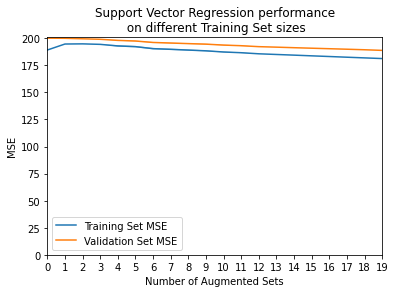

In [113]:
start_time = time.time()
svr = SVR(kernel = "rbf", cache_size=7000)
# No hyperparameter tuning since it would take far too long
best_duplicates_to_keep, best_size = learning_curve('Support Vector Regression', svr, XX, YY, True)
print("Time taken: ", time.time() - start_time)

In [18]:
best_duplicates_to_keep = 19

Grid Search Cross Validation for Inititalization with Hyperparameter Tuning

In [19]:
start_time = time.time()
modified_XX, modified_YY = reduce_dataset_size(XX, YY, get_rand_studyseqs(best_duplicates_to_keep))
modified_XX_train, modified_YY_train, modified_XX_test, modified_YY_test = split_by_cond(modified_XX, modified_YY, 'Cond_SE')
modified_XX_train, modified_YY_train = modified_XX_train.iloc[:,2:], modified_YY_train.iloc[:,2:] # drop cond and studyseq columns
modified_YY_train = modified_YY_train.values.flatten()

param_grid = {"C": np.logspace(-2, 2, num=5), "gamma": np.logspace(-6, 2, num=9), "epsilon": np.logspace(-3, 6, num=10)}
# 8 fold with shuffle=False holds one cond out on each inner fold of the predicted_vs_true function
kfolds = KFold(n_splits = 8, shuffle = False)
svr = GridSearchCV(estimator = SVR(kernel = "rbf", cache_size=7000), param_grid = param_grid, scoring = "neg_mean_squared_error",
                   cv=kfolds, verbose=5)
svr.fit(modified_XX_train, modified_YY_train)

svr_init_params = svr.best_params_
print("Time taken: ", time.time() - start_time)

Fitting 8 folds for each of 450 candidates, totalling 3600 fits
[CV 1/8] END .............C=0.01, epsilon=0.001, gamma=1e-06; total time=   4.6s
[CV 2/8] END .............C=0.01, epsilon=0.001, gamma=1e-06; total time=   4.4s
[CV 3/8] END .............C=0.01, epsilon=0.001, gamma=1e-06; total time=   4.7s
[CV 4/8] END .............C=0.01, epsilon=0.001, gamma=1e-06; total time=   4.8s
[CV 5/8] END .............C=0.01, epsilon=0.001, gamma=1e-06; total time=   4.8s
[CV 6/8] END .............C=0.01, epsilon=0.001, gamma=1e-06; total time=   5.1s
[CV 7/8] END .............C=0.01, epsilon=0.001, gamma=1e-06; total time=   4.6s
[CV 8/8] END .............C=0.01, epsilon=0.001, gamma=1e-06; total time=   4.7s
[CV 1/8] END .............C=0.01, epsilon=0.001, gamma=1e-05; total time=   4.8s
[CV 2/8] END .............C=0.01, epsilon=0.001, gamma=1e-05; total time=   5.4s
[CV 3/8] END .............C=0.01, epsilon=0.001, gamma=1e-05; total time=   7.2s
[CV 4/8] END .............C=0.01, epsilon=0.0

[CV 6/8] END ..............C=0.01, epsilon=0.01, gamma=0.001; total time=   5.3s
[CV 7/8] END ..............C=0.01, epsilon=0.01, gamma=0.001; total time=   4.6s
[CV 8/8] END ..............C=0.01, epsilon=0.01, gamma=0.001; total time=   4.6s
[CV 1/8] END ...............C=0.01, epsilon=0.01, gamma=0.01; total time=   5.0s
[CV 2/8] END ...............C=0.01, epsilon=0.01, gamma=0.01; total time=   4.8s
[CV 3/8] END ...............C=0.01, epsilon=0.01, gamma=0.01; total time=   4.6s
[CV 4/8] END ...............C=0.01, epsilon=0.01, gamma=0.01; total time=   4.7s
[CV 5/8] END ...............C=0.01, epsilon=0.01, gamma=0.01; total time=   5.1s
[CV 6/8] END ...............C=0.01, epsilon=0.01, gamma=0.01; total time=   6.9s
[CV 7/8] END ...............C=0.01, epsilon=0.01, gamma=0.01; total time=   5.1s
[CV 8/8] END ...............C=0.01, epsilon=0.01, gamma=0.01; total time=   4.5s
[CV 1/8] END ................C=0.01, epsilon=0.01, gamma=0.1; total time=   4.4s
[CV 2/8] END ...............

[CV 4/8] END ................C=0.01, epsilon=0.1, gamma=10.0; total time=   4.9s
[CV 5/8] END ................C=0.01, epsilon=0.1, gamma=10.0; total time=   5.2s
[CV 6/8] END ................C=0.01, epsilon=0.1, gamma=10.0; total time=   4.9s
[CV 7/8] END ................C=0.01, epsilon=0.1, gamma=10.0; total time=   5.0s
[CV 8/8] END ................C=0.01, epsilon=0.1, gamma=10.0; total time=   5.0s
[CV 1/8] END ...............C=0.01, epsilon=0.1, gamma=100.0; total time=   5.3s
[CV 2/8] END ...............C=0.01, epsilon=0.1, gamma=100.0; total time=   5.6s
[CV 3/8] END ...............C=0.01, epsilon=0.1, gamma=100.0; total time=   5.3s
[CV 4/8] END ...............C=0.01, epsilon=0.1, gamma=100.0; total time=   5.5s
[CV 5/8] END ...............C=0.01, epsilon=0.1, gamma=100.0; total time=   5.8s
[CV 6/8] END ...............C=0.01, epsilon=0.1, gamma=100.0; total time=   5.2s
[CV 7/8] END ...............C=0.01, epsilon=0.1, gamma=100.0; total time=   5.1s
[CV 8/8] END ...............

[CV 2/8] END .............C=0.01, epsilon=10.0, gamma=0.0001; total time=   2.0s
[CV 3/8] END .............C=0.01, epsilon=10.0, gamma=0.0001; total time=   1.5s
[CV 4/8] END .............C=0.01, epsilon=10.0, gamma=0.0001; total time=   1.8s
[CV 5/8] END .............C=0.01, epsilon=10.0, gamma=0.0001; total time=   2.0s
[CV 6/8] END .............C=0.01, epsilon=10.0, gamma=0.0001; total time=   2.1s
[CV 7/8] END .............C=0.01, epsilon=10.0, gamma=0.0001; total time=   2.1s
[CV 8/8] END .............C=0.01, epsilon=10.0, gamma=0.0001; total time=   2.1s
[CV 1/8] END ..............C=0.01, epsilon=10.0, gamma=0.001; total time=   2.2s
[CV 2/8] END ..............C=0.01, epsilon=10.0, gamma=0.001; total time=   2.1s
[CV 3/8] END ..............C=0.01, epsilon=10.0, gamma=0.001; total time=   1.6s
[CV 4/8] END ..............C=0.01, epsilon=10.0, gamma=0.001; total time=   1.8s
[CV 5/8] END ..............C=0.01, epsilon=10.0, gamma=0.001; total time=   2.0s
[CV 6/8] END ..............C

[CV 2/8] END ...............C=0.01, epsilon=100.0, gamma=1.0; total time=   0.0s
[CV 3/8] END ...............C=0.01, epsilon=100.0, gamma=1.0; total time=   0.0s
[CV 4/8] END ...............C=0.01, epsilon=100.0, gamma=1.0; total time=   0.0s
[CV 5/8] END ...............C=0.01, epsilon=100.0, gamma=1.0; total time=   0.0s
[CV 6/8] END ...............C=0.01, epsilon=100.0, gamma=1.0; total time=   0.0s
[CV 7/8] END ...............C=0.01, epsilon=100.0, gamma=1.0; total time=   0.0s
[CV 8/8] END ...............C=0.01, epsilon=100.0, gamma=1.0; total time=   0.0s
[CV 1/8] END ..............C=0.01, epsilon=100.0, gamma=10.0; total time=   0.0s
[CV 2/8] END ..............C=0.01, epsilon=100.0, gamma=10.0; total time=   0.0s
[CV 3/8] END ..............C=0.01, epsilon=100.0, gamma=10.0; total time=   0.0s
[CV 4/8] END ..............C=0.01, epsilon=100.0, gamma=10.0; total time=   0.0s
[CV 5/8] END ..............C=0.01, epsilon=100.0, gamma=10.0; total time=   0.0s
[CV 6/8] END ..............C

[CV 1/8] END ..........C=0.01, epsilon=10000.0, gamma=0.0001; total time=   0.0s
[CV 2/8] END ..........C=0.01, epsilon=10000.0, gamma=0.0001; total time=   0.0s
[CV 3/8] END ..........C=0.01, epsilon=10000.0, gamma=0.0001; total time=   0.0s
[CV 4/8] END ..........C=0.01, epsilon=10000.0, gamma=0.0001; total time=   0.0s
[CV 5/8] END ..........C=0.01, epsilon=10000.0, gamma=0.0001; total time=   0.0s
[CV 6/8] END ..........C=0.01, epsilon=10000.0, gamma=0.0001; total time=   0.0s
[CV 7/8] END ..........C=0.01, epsilon=10000.0, gamma=0.0001; total time=   0.0s
[CV 8/8] END ..........C=0.01, epsilon=10000.0, gamma=0.0001; total time=   0.0s
[CV 1/8] END ...........C=0.01, epsilon=10000.0, gamma=0.001; total time=   0.0s
[CV 2/8] END ...........C=0.01, epsilon=10000.0, gamma=0.001; total time=   0.0s
[CV 3/8] END ...........C=0.01, epsilon=10000.0, gamma=0.001; total time=   0.0s
[CV 4/8] END ...........C=0.01, epsilon=10000.0, gamma=0.001; total time=   0.0s
[CV 5/8] END ...........C=0.

[CV 3/8] END ...........C=0.01, epsilon=100000.0, gamma=10.0; total time=   0.0s
[CV 4/8] END ...........C=0.01, epsilon=100000.0, gamma=10.0; total time=   0.0s
[CV 5/8] END ...........C=0.01, epsilon=100000.0, gamma=10.0; total time=   0.0s
[CV 6/8] END ...........C=0.01, epsilon=100000.0, gamma=10.0; total time=   0.0s
[CV 7/8] END ...........C=0.01, epsilon=100000.0, gamma=10.0; total time=   0.0s
[CV 8/8] END ...........C=0.01, epsilon=100000.0, gamma=10.0; total time=   0.0s
[CV 1/8] END ..........C=0.01, epsilon=100000.0, gamma=100.0; total time=   0.0s
[CV 2/8] END ..........C=0.01, epsilon=100000.0, gamma=100.0; total time=   0.0s
[CV 3/8] END ..........C=0.01, epsilon=100000.0, gamma=100.0; total time=   0.0s
[CV 4/8] END ..........C=0.01, epsilon=100000.0, gamma=100.0; total time=   0.0s
[CV 5/8] END ..........C=0.01, epsilon=100000.0, gamma=100.0; total time=   0.0s
[CV 6/8] END ..........C=0.01, epsilon=100000.0, gamma=100.0; total time=   0.0s
[CV 7/8] END ..........C=0.0

[CV 1/8] END .............C=0.1, epsilon=0.001, gamma=0.0001; total time=   4.6s
[CV 2/8] END .............C=0.1, epsilon=0.001, gamma=0.0001; total time=   4.7s
[CV 3/8] END .............C=0.1, epsilon=0.001, gamma=0.0001; total time=   4.7s
[CV 4/8] END .............C=0.1, epsilon=0.001, gamma=0.0001; total time=   4.9s
[CV 5/8] END .............C=0.1, epsilon=0.001, gamma=0.0001; total time=   4.8s
[CV 6/8] END .............C=0.1, epsilon=0.001, gamma=0.0001; total time=   4.7s
[CV 7/8] END .............C=0.1, epsilon=0.001, gamma=0.0001; total time=   5.3s
[CV 8/8] END .............C=0.1, epsilon=0.001, gamma=0.0001; total time=   4.8s
[CV 1/8] END ..............C=0.1, epsilon=0.001, gamma=0.001; total time=   4.8s
[CV 2/8] END ..............C=0.1, epsilon=0.001, gamma=0.001; total time=   6.3s
[CV 3/8] END ..............C=0.1, epsilon=0.001, gamma=0.001; total time=   4.8s
[CV 4/8] END ..............C=0.1, epsilon=0.001, gamma=0.001; total time=   4.9s
[CV 5/8] END ..............C

[CV 7/8] END .................C=0.1, epsilon=0.01, gamma=0.1; total time=   4.5s
[CV 8/8] END .................C=0.1, epsilon=0.01, gamma=0.1; total time=   4.6s
[CV 1/8] END .................C=0.1, epsilon=0.01, gamma=1.0; total time=   4.5s
[CV 2/8] END .................C=0.1, epsilon=0.01, gamma=1.0; total time=   4.8s
[CV 3/8] END .................C=0.1, epsilon=0.01, gamma=1.0; total time=   5.0s
[CV 4/8] END .................C=0.1, epsilon=0.01, gamma=1.0; total time=   5.6s
[CV 5/8] END .................C=0.1, epsilon=0.01, gamma=1.0; total time=   4.9s
[CV 6/8] END .................C=0.1, epsilon=0.01, gamma=1.0; total time=   6.0s
[CV 7/8] END .................C=0.1, epsilon=0.01, gamma=1.0; total time=   5.6s
[CV 8/8] END .................C=0.1, epsilon=0.01, gamma=1.0; total time=   5.4s
[CV 1/8] END ................C=0.1, epsilon=0.01, gamma=10.0; total time=   5.0s
[CV 2/8] END ................C=0.1, epsilon=0.01, gamma=10.0; total time=   5.1s
[CV 3/8] END ...............

[CV 5/8] END ................C=0.1, epsilon=1.0, gamma=1e-06; total time=   4.2s
[CV 6/8] END ................C=0.1, epsilon=1.0, gamma=1e-06; total time=   4.9s
[CV 7/8] END ................C=0.1, epsilon=1.0, gamma=1e-06; total time=   4.9s
[CV 8/8] END ................C=0.1, epsilon=1.0, gamma=1e-06; total time=   4.3s
[CV 1/8] END ................C=0.1, epsilon=1.0, gamma=1e-05; total time=   4.2s
[CV 2/8] END ................C=0.1, epsilon=1.0, gamma=1e-05; total time=   4.1s
[CV 3/8] END ................C=0.1, epsilon=1.0, gamma=1e-05; total time=   4.1s
[CV 4/8] END ................C=0.1, epsilon=1.0, gamma=1e-05; total time=   4.0s
[CV 5/8] END ................C=0.1, epsilon=1.0, gamma=1e-05; total time=   4.2s
[CV 6/8] END ................C=0.1, epsilon=1.0, gamma=1e-05; total time=   4.0s
[CV 7/8] END ................C=0.1, epsilon=1.0, gamma=1e-05; total time=   4.2s
[CV 8/8] END ................C=0.1, epsilon=1.0, gamma=1e-05; total time=   4.2s
[CV 1/8] END ...............

[CV 3/8] END ................C=0.1, epsilon=10.0, gamma=0.01; total time=   1.4s
[CV 4/8] END ................C=0.1, epsilon=10.0, gamma=0.01; total time=   1.7s
[CV 5/8] END ................C=0.1, epsilon=10.0, gamma=0.01; total time=   1.9s
[CV 6/8] END ................C=0.1, epsilon=10.0, gamma=0.01; total time=   2.0s
[CV 7/8] END ................C=0.1, epsilon=10.0, gamma=0.01; total time=   1.9s
[CV 8/8] END ................C=0.1, epsilon=10.0, gamma=0.01; total time=   2.0s
[CV 1/8] END .................C=0.1, epsilon=10.0, gamma=0.1; total time=   1.7s
[CV 2/8] END .................C=0.1, epsilon=10.0, gamma=0.1; total time=   1.6s
[CV 3/8] END .................C=0.1, epsilon=10.0, gamma=0.1; total time=   1.3s
[CV 4/8] END .................C=0.1, epsilon=10.0, gamma=0.1; total time=   1.6s
[CV 5/8] END .................C=0.1, epsilon=10.0, gamma=0.1; total time=   1.6s
[CV 6/8] END .................C=0.1, epsilon=10.0, gamma=0.1; total time=   1.7s
[CV 7/8] END ...............

[CV 2/8] END .............C=0.1, epsilon=1000.0, gamma=1e-06; total time=   0.0s
[CV 3/8] END .............C=0.1, epsilon=1000.0, gamma=1e-06; total time=   0.0s
[CV 4/8] END .............C=0.1, epsilon=1000.0, gamma=1e-06; total time=   0.0s
[CV 5/8] END .............C=0.1, epsilon=1000.0, gamma=1e-06; total time=   0.0s
[CV 6/8] END .............C=0.1, epsilon=1000.0, gamma=1e-06; total time=   0.0s
[CV 7/8] END .............C=0.1, epsilon=1000.0, gamma=1e-06; total time=   0.0s
[CV 8/8] END .............C=0.1, epsilon=1000.0, gamma=1e-06; total time=   0.0s
[CV 1/8] END .............C=0.1, epsilon=1000.0, gamma=1e-05; total time=   0.0s
[CV 2/8] END .............C=0.1, epsilon=1000.0, gamma=1e-05; total time=   0.0s
[CV 3/8] END .............C=0.1, epsilon=1000.0, gamma=1e-05; total time=   0.0s
[CV 4/8] END .............C=0.1, epsilon=1000.0, gamma=1e-05; total time=   0.0s
[CV 5/8] END .............C=0.1, epsilon=1000.0, gamma=1e-05; total time=   0.0s
[CV 6/8] END .............C=

[CV 3/8] END ..............C=0.1, epsilon=10000.0, gamma=0.1; total time=   0.0s
[CV 4/8] END ..............C=0.1, epsilon=10000.0, gamma=0.1; total time=   0.0s
[CV 5/8] END ..............C=0.1, epsilon=10000.0, gamma=0.1; total time=   0.0s
[CV 6/8] END ..............C=0.1, epsilon=10000.0, gamma=0.1; total time=   0.0s
[CV 7/8] END ..............C=0.1, epsilon=10000.0, gamma=0.1; total time=   0.0s
[CV 8/8] END ..............C=0.1, epsilon=10000.0, gamma=0.1; total time=   0.0s
[CV 1/8] END ..............C=0.1, epsilon=10000.0, gamma=1.0; total time=   0.0s
[CV 2/8] END ..............C=0.1, epsilon=10000.0, gamma=1.0; total time=   0.0s
[CV 3/8] END ..............C=0.1, epsilon=10000.0, gamma=1.0; total time=   0.0s
[CV 4/8] END ..............C=0.1, epsilon=10000.0, gamma=1.0; total time=   0.0s
[CV 5/8] END ..............C=0.1, epsilon=10000.0, gamma=1.0; total time=   0.0s
[CV 6/8] END ..............C=0.1, epsilon=10000.0, gamma=1.0; total time=   0.0s
[CV 7/8] END ..............C

[CV 4/8] END ..........C=0.1, epsilon=1000000.0, gamma=1e-05; total time=   0.0s
[CV 5/8] END ..........C=0.1, epsilon=1000000.0, gamma=1e-05; total time=   0.0s
[CV 6/8] END ..........C=0.1, epsilon=1000000.0, gamma=1e-05; total time=   0.0s
[CV 7/8] END ..........C=0.1, epsilon=1000000.0, gamma=1e-05; total time=   0.0s
[CV 8/8] END ..........C=0.1, epsilon=1000000.0, gamma=1e-05; total time=   0.0s
[CV 1/8] END .........C=0.1, epsilon=1000000.0, gamma=0.0001; total time=   0.0s
[CV 2/8] END .........C=0.1, epsilon=1000000.0, gamma=0.0001; total time=   0.0s
[CV 3/8] END .........C=0.1, epsilon=1000000.0, gamma=0.0001; total time=   0.0s
[CV 4/8] END .........C=0.1, epsilon=1000000.0, gamma=0.0001; total time=   0.0s
[CV 5/8] END .........C=0.1, epsilon=1000000.0, gamma=0.0001; total time=   0.0s
[CV 6/8] END .........C=0.1, epsilon=1000000.0, gamma=0.0001; total time=   0.0s
[CV 7/8] END .........C=0.1, epsilon=1000000.0, gamma=0.0001; total time=   0.0s
[CV 8/8] END .........C=0.1,

[CV 2/8] END ................C=1.0, epsilon=0.001, gamma=0.1; total time=   5.2s
[CV 3/8] END ................C=1.0, epsilon=0.001, gamma=0.1; total time=   5.6s
[CV 4/8] END ................C=1.0, epsilon=0.001, gamma=0.1; total time=   5.7s
[CV 5/8] END ................C=1.0, epsilon=0.001, gamma=0.1; total time=   5.3s
[CV 6/8] END ................C=1.0, epsilon=0.001, gamma=0.1; total time=   5.2s
[CV 7/8] END ................C=1.0, epsilon=0.001, gamma=0.1; total time=   5.0s
[CV 8/8] END ................C=1.0, epsilon=0.001, gamma=0.1; total time=   5.1s
[CV 1/8] END ................C=1.0, epsilon=0.001, gamma=1.0; total time=   7.0s
[CV 2/8] END ................C=1.0, epsilon=0.001, gamma=1.0; total time=   8.1s
[CV 3/8] END ................C=1.0, epsilon=0.001, gamma=1.0; total time=   7.8s
[CV 4/8] END ................C=1.0, epsilon=0.001, gamma=1.0; total time=   7.4s
[CV 5/8] END ................C=1.0, epsilon=0.001, gamma=1.0; total time=   7.5s
[CV 6/8] END ...............

[CV 8/8] END ...............C=1.0, epsilon=0.01, gamma=100.0; total time=   7.4s
[CV 1/8] END ................C=1.0, epsilon=0.1, gamma=1e-06; total time=   5.1s
[CV 2/8] END ................C=1.0, epsilon=0.1, gamma=1e-06; total time=   5.1s
[CV 3/8] END ................C=1.0, epsilon=0.1, gamma=1e-06; total time=   5.1s
[CV 4/8] END ................C=1.0, epsilon=0.1, gamma=1e-06; total time=   5.0s
[CV 5/8] END ................C=1.0, epsilon=0.1, gamma=1e-06; total time=   5.5s
[CV 6/8] END ................C=1.0, epsilon=0.1, gamma=1e-06; total time=   5.6s
[CV 7/8] END ................C=1.0, epsilon=0.1, gamma=1e-06; total time=   5.3s
[CV 8/8] END ................C=1.0, epsilon=0.1, gamma=1e-06; total time=   5.6s
[CV 1/8] END ................C=1.0, epsilon=0.1, gamma=1e-05; total time=   5.4s
[CV 2/8] END ................C=1.0, epsilon=0.1, gamma=1e-05; total time=   4.6s
[CV 3/8] END ................C=1.0, epsilon=0.1, gamma=1e-05; total time=   4.7s
[CV 4/8] END ...............

[CV 6/8] END ................C=1.0, epsilon=1.0, gamma=0.001; total time=   4.2s
[CV 7/8] END ................C=1.0, epsilon=1.0, gamma=0.001; total time=   4.3s
[CV 8/8] END ................C=1.0, epsilon=1.0, gamma=0.001; total time=   4.4s
[CV 1/8] END .................C=1.0, epsilon=1.0, gamma=0.01; total time=   4.1s
[CV 2/8] END .................C=1.0, epsilon=1.0, gamma=0.01; total time=   4.0s
[CV 3/8] END .................C=1.0, epsilon=1.0, gamma=0.01; total time=   4.3s
[CV 4/8] END .................C=1.0, epsilon=1.0, gamma=0.01; total time=   4.3s
[CV 5/8] END .................C=1.0, epsilon=1.0, gamma=0.01; total time=   4.2s
[CV 6/8] END .................C=1.0, epsilon=1.0, gamma=0.01; total time=   4.3s
[CV 7/8] END .................C=1.0, epsilon=1.0, gamma=0.01; total time=   4.3s
[CV 8/8] END .................C=1.0, epsilon=1.0, gamma=0.01; total time=   4.1s
[CV 1/8] END ..................C=1.0, epsilon=1.0, gamma=0.1; total time=   4.7s
[CV 2/8] END ...............

[CV 4/8] END ................C=1.0, epsilon=10.0, gamma=10.0; total time=   3.1s
[CV 5/8] END ................C=1.0, epsilon=10.0, gamma=10.0; total time=   3.1s
[CV 6/8] END ................C=1.0, epsilon=10.0, gamma=10.0; total time=   3.9s
[CV 7/8] END ................C=1.0, epsilon=10.0, gamma=10.0; total time=   4.1s
[CV 8/8] END ................C=1.0, epsilon=10.0, gamma=10.0; total time=   4.6s
[CV 1/8] END ...............C=1.0, epsilon=10.0, gamma=100.0; total time=   3.6s
[CV 2/8] END ...............C=1.0, epsilon=10.0, gamma=100.0; total time=   3.2s
[CV 3/8] END ...............C=1.0, epsilon=10.0, gamma=100.0; total time=   2.8s
[CV 4/8] END ...............C=1.0, epsilon=10.0, gamma=100.0; total time=   2.7s
[CV 5/8] END ...............C=1.0, epsilon=10.0, gamma=100.0; total time=   3.3s
[CV 6/8] END ...............C=1.0, epsilon=10.0, gamma=100.0; total time=   3.7s
[CV 7/8] END ...............C=1.0, epsilon=10.0, gamma=100.0; total time=   3.4s
[CV 8/8] END ...............

[CV 6/8] END .............C=1.0, epsilon=1000.0, gamma=0.001; total time=   0.0s
[CV 7/8] END .............C=1.0, epsilon=1000.0, gamma=0.001; total time=   0.0s
[CV 8/8] END .............C=1.0, epsilon=1000.0, gamma=0.001; total time=   0.0s
[CV 1/8] END ..............C=1.0, epsilon=1000.0, gamma=0.01; total time=   0.0s
[CV 2/8] END ..............C=1.0, epsilon=1000.0, gamma=0.01; total time=   0.0s
[CV 3/8] END ..............C=1.0, epsilon=1000.0, gamma=0.01; total time=   0.0s
[CV 4/8] END ..............C=1.0, epsilon=1000.0, gamma=0.01; total time=   0.0s
[CV 5/8] END ..............C=1.0, epsilon=1000.0, gamma=0.01; total time=   0.0s
[CV 6/8] END ..............C=1.0, epsilon=1000.0, gamma=0.01; total time=   0.0s
[CV 7/8] END ..............C=1.0, epsilon=1000.0, gamma=0.01; total time=   0.0s
[CV 8/8] END ..............C=1.0, epsilon=1000.0, gamma=0.01; total time=   0.0s
[CV 1/8] END ...............C=1.0, epsilon=1000.0, gamma=0.1; total time=   0.0s
[CV 2/8] END ...............

[CV 6/8] END ............C=1.0, epsilon=10000.0, gamma=100.0; total time=   0.0s
[CV 7/8] END ............C=1.0, epsilon=10000.0, gamma=100.0; total time=   0.0s
[CV 8/8] END ............C=1.0, epsilon=10000.0, gamma=100.0; total time=   0.0s
[CV 1/8] END ...........C=1.0, epsilon=100000.0, gamma=1e-06; total time=   0.0s
[CV 2/8] END ...........C=1.0, epsilon=100000.0, gamma=1e-06; total time=   0.0s
[CV 3/8] END ...........C=1.0, epsilon=100000.0, gamma=1e-06; total time=   0.0s
[CV 4/8] END ...........C=1.0, epsilon=100000.0, gamma=1e-06; total time=   0.0s
[CV 5/8] END ...........C=1.0, epsilon=100000.0, gamma=1e-06; total time=   0.0s
[CV 6/8] END ...........C=1.0, epsilon=100000.0, gamma=1e-06; total time=   0.0s
[CV 7/8] END ...........C=1.0, epsilon=100000.0, gamma=1e-06; total time=   0.0s
[CV 8/8] END ...........C=1.0, epsilon=100000.0, gamma=1e-06; total time=   0.0s
[CV 1/8] END ...........C=1.0, epsilon=100000.0, gamma=1e-05; total time=   0.0s
[CV 2/8] END ...........C=1.

[CV 4/8] END ..........C=1.0, epsilon=1000000.0, gamma=0.001; total time=   0.0s
[CV 5/8] END ..........C=1.0, epsilon=1000000.0, gamma=0.001; total time=   0.0s
[CV 6/8] END ..........C=1.0, epsilon=1000000.0, gamma=0.001; total time=   0.0s
[CV 7/8] END ..........C=1.0, epsilon=1000000.0, gamma=0.001; total time=   0.0s
[CV 8/8] END ..........C=1.0, epsilon=1000000.0, gamma=0.001; total time=   0.0s
[CV 1/8] END ...........C=1.0, epsilon=1000000.0, gamma=0.01; total time=   0.0s
[CV 2/8] END ...........C=1.0, epsilon=1000000.0, gamma=0.01; total time=   0.0s
[CV 3/8] END ...........C=1.0, epsilon=1000000.0, gamma=0.01; total time=   0.0s
[CV 4/8] END ...........C=1.0, epsilon=1000000.0, gamma=0.01; total time=   0.0s
[CV 5/8] END ...........C=1.0, epsilon=1000000.0, gamma=0.01; total time=   0.0s
[CV 6/8] END ...........C=1.0, epsilon=1000000.0, gamma=0.01; total time=   0.0s
[CV 7/8] END ...........C=1.0, epsilon=1000000.0, gamma=0.01; total time=   0.0s
[CV 8/8] END ...........C=1.

[CV 2/8] END ..............C=10.0, epsilon=0.001, gamma=10.0; total time=  31.6s
[CV 3/8] END ..............C=10.0, epsilon=0.001, gamma=10.0; total time=  38.6s
[CV 4/8] END ..............C=10.0, epsilon=0.001, gamma=10.0; total time=  31.3s
[CV 5/8] END ..............C=10.0, epsilon=0.001, gamma=10.0; total time=  29.7s
[CV 6/8] END ..............C=10.0, epsilon=0.001, gamma=10.0; total time=  30.3s
[CV 7/8] END ..............C=10.0, epsilon=0.001, gamma=10.0; total time=  29.2s
[CV 8/8] END ..............C=10.0, epsilon=0.001, gamma=10.0; total time=  28.4s
[CV 1/8] END .............C=10.0, epsilon=0.001, gamma=100.0; total time=  20.3s
[CV 2/8] END .............C=10.0, epsilon=0.001, gamma=100.0; total time=  20.3s
[CV 3/8] END .............C=10.0, epsilon=0.001, gamma=100.0; total time=  20.5s
[CV 4/8] END .............C=10.0, epsilon=0.001, gamma=100.0; total time=  20.0s
[CV 5/8] END .............C=10.0, epsilon=0.001, gamma=100.0; total time=  20.1s
[CV 6/8] END .............C=

[CV 8/8] END ...............C=10.0, epsilon=0.1, gamma=1e-05; total time=   5.5s
[CV 1/8] END ..............C=10.0, epsilon=0.1, gamma=0.0001; total time=   5.2s
[CV 2/8] END ..............C=10.0, epsilon=0.1, gamma=0.0001; total time=   5.3s
[CV 3/8] END ..............C=10.0, epsilon=0.1, gamma=0.0001; total time=   5.3s
[CV 4/8] END ..............C=10.0, epsilon=0.1, gamma=0.0001; total time=   4.8s
[CV 5/8] END ..............C=10.0, epsilon=0.1, gamma=0.0001; total time=   4.9s
[CV 6/8] END ..............C=10.0, epsilon=0.1, gamma=0.0001; total time=   4.7s
[CV 7/8] END ..............C=10.0, epsilon=0.1, gamma=0.0001; total time=   4.9s
[CV 8/8] END ..............C=10.0, epsilon=0.1, gamma=0.0001; total time=   4.8s
[CV 1/8] END ...............C=10.0, epsilon=0.1, gamma=0.001; total time=   4.8s
[CV 2/8] END ...............C=10.0, epsilon=0.1, gamma=0.001; total time=   4.9s
[CV 3/8] END ...............C=10.0, epsilon=0.1, gamma=0.001; total time=   4.8s
[CV 4/8] END ...............

[CV 6/8] END .................C=10.0, epsilon=1.0, gamma=0.1; total time=  11.5s
[CV 7/8] END .................C=10.0, epsilon=1.0, gamma=0.1; total time=  12.0s
[CV 8/8] END .................C=10.0, epsilon=1.0, gamma=0.1; total time=  12.4s
[CV 1/8] END .................C=10.0, epsilon=1.0, gamma=1.0; total time=  18.8s
[CV 2/8] END .................C=10.0, epsilon=1.0, gamma=1.0; total time=  17.9s
[CV 3/8] END .................C=10.0, epsilon=1.0, gamma=1.0; total time=  18.7s
[CV 4/8] END .................C=10.0, epsilon=1.0, gamma=1.0; total time=  19.7s
[CV 5/8] END .................C=10.0, epsilon=1.0, gamma=1.0; total time=  21.5s
[CV 6/8] END .................C=10.0, epsilon=1.0, gamma=1.0; total time=  22.5s
[CV 7/8] END .................C=10.0, epsilon=1.0, gamma=1.0; total time=  21.2s
[CV 8/8] END .................C=10.0, epsilon=1.0, gamma=1.0; total time=  17.7s
[CV 1/8] END ................C=10.0, epsilon=1.0, gamma=10.0; total time=  17.6s
[CV 2/8] END ...............

[CV 4/8] END .............C=10.0, epsilon=100.0, gamma=1e-05; total time=   0.0s
[CV 5/8] END .............C=10.0, epsilon=100.0, gamma=1e-05; total time=   0.0s
[CV 6/8] END .............C=10.0, epsilon=100.0, gamma=1e-05; total time=   0.0s
[CV 7/8] END .............C=10.0, epsilon=100.0, gamma=1e-05; total time=   0.0s
[CV 8/8] END .............C=10.0, epsilon=100.0, gamma=1e-05; total time=   0.0s
[CV 1/8] END ............C=10.0, epsilon=100.0, gamma=0.0001; total time=   0.0s
[CV 2/8] END ............C=10.0, epsilon=100.0, gamma=0.0001; total time=   0.0s
[CV 3/8] END ............C=10.0, epsilon=100.0, gamma=0.0001; total time=   0.0s
[CV 4/8] END ............C=10.0, epsilon=100.0, gamma=0.0001; total time=   0.0s
[CV 5/8] END ............C=10.0, epsilon=100.0, gamma=0.0001; total time=   0.0s
[CV 6/8] END ............C=10.0, epsilon=100.0, gamma=0.0001; total time=   0.0s
[CV 7/8] END ............C=10.0, epsilon=100.0, gamma=0.0001; total time=   0.0s
[CV 8/8] END ............C=1

[CV 1/8] END ..............C=10.0, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 2/8] END ..............C=10.0, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 3/8] END ..............C=10.0, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 4/8] END ..............C=10.0, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 5/8] END ..............C=10.0, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 6/8] END ..............C=10.0, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 7/8] END ..............C=10.0, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 8/8] END ..............C=10.0, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 1/8] END .............C=10.0, epsilon=1000.0, gamma=10.0; total time=   0.0s
[CV 2/8] END .............C=10.0, epsilon=1000.0, gamma=10.0; total time=   0.0s
[CV 3/8] END .............C=10.0, epsilon=1000.0, gamma=10.0; total time=   0.0s
[CV 4/8] END .............C=10.0, epsilon=1000.0, gamma=10.0; total time=   0.0s
[CV 5/8] END .............C=

[CV 5/8] END ..........C=10.0, epsilon=100000.0, gamma=1e-05; total time=   0.0s
[CV 6/8] END ..........C=10.0, epsilon=100000.0, gamma=1e-05; total time=   0.0s
[CV 7/8] END ..........C=10.0, epsilon=100000.0, gamma=1e-05; total time=   0.0s
[CV 8/8] END ..........C=10.0, epsilon=100000.0, gamma=1e-05; total time=   0.0s
[CV 1/8] END .........C=10.0, epsilon=100000.0, gamma=0.0001; total time=   0.0s
[CV 2/8] END .........C=10.0, epsilon=100000.0, gamma=0.0001; total time=   0.0s
[CV 3/8] END .........C=10.0, epsilon=100000.0, gamma=0.0001; total time=   0.0s
[CV 4/8] END .........C=10.0, epsilon=100000.0, gamma=0.0001; total time=   0.0s
[CV 5/8] END .........C=10.0, epsilon=100000.0, gamma=0.0001; total time=   0.0s
[CV 6/8] END .........C=10.0, epsilon=100000.0, gamma=0.0001; total time=   0.0s
[CV 7/8] END .........C=10.0, epsilon=100000.0, gamma=0.0001; total time=   0.0s
[CV 8/8] END .........C=10.0, epsilon=100000.0, gamma=0.0001; total time=   0.0s
[CV 1/8] END ..........C=10.

[CV 3/8] END ...........C=10.0, epsilon=1000000.0, gamma=0.1; total time=   0.0s
[CV 4/8] END ...........C=10.0, epsilon=1000000.0, gamma=0.1; total time=   0.0s
[CV 5/8] END ...........C=10.0, epsilon=1000000.0, gamma=0.1; total time=   0.0s
[CV 6/8] END ...........C=10.0, epsilon=1000000.0, gamma=0.1; total time=   0.0s
[CV 7/8] END ...........C=10.0, epsilon=1000000.0, gamma=0.1; total time=   0.0s
[CV 8/8] END ...........C=10.0, epsilon=1000000.0, gamma=0.1; total time=   0.0s
[CV 1/8] END ...........C=10.0, epsilon=1000000.0, gamma=1.0; total time=   0.0s
[CV 2/8] END ...........C=10.0, epsilon=1000000.0, gamma=1.0; total time=   0.0s
[CV 3/8] END ...........C=10.0, epsilon=1000000.0, gamma=1.0; total time=   0.0s
[CV 4/8] END ...........C=10.0, epsilon=1000000.0, gamma=1.0; total time=   0.0s
[CV 5/8] END ...........C=10.0, epsilon=1000000.0, gamma=1.0; total time=   0.0s
[CV 6/8] END ...........C=10.0, epsilon=1000000.0, gamma=1.0; total time=   0.0s
[CV 7/8] END ...........C=10

[CV 1/8] END .............C=100.0, epsilon=0.01, gamma=1e-06; total time=   4.9s
[CV 2/8] END .............C=100.0, epsilon=0.01, gamma=1e-06; total time=   5.0s
[CV 3/8] END .............C=100.0, epsilon=0.01, gamma=1e-06; total time=   5.4s
[CV 4/8] END .............C=100.0, epsilon=0.01, gamma=1e-06; total time=   5.1s
[CV 5/8] END .............C=100.0, epsilon=0.01, gamma=1e-06; total time=   5.2s
[CV 6/8] END .............C=100.0, epsilon=0.01, gamma=1e-06; total time=   5.2s
[CV 7/8] END .............C=100.0, epsilon=0.01, gamma=1e-06; total time=   5.2s
[CV 8/8] END .............C=100.0, epsilon=0.01, gamma=1e-06; total time=   5.1s
[CV 1/8] END .............C=100.0, epsilon=0.01, gamma=1e-05; total time=   4.9s
[CV 2/8] END .............C=100.0, epsilon=0.01, gamma=1e-05; total time=   4.9s
[CV 3/8] END .............C=100.0, epsilon=0.01, gamma=1e-05; total time=   5.1s
[CV 4/8] END .............C=100.0, epsilon=0.01, gamma=1e-05; total time=   5.3s
[CV 5/8] END .............C=

[CV 7/8] END ..............C=100.0, epsilon=0.1, gamma=0.001; total time=   7.9s
[CV 8/8] END ..............C=100.0, epsilon=0.1, gamma=0.001; total time=   7.7s
[CV 1/8] END ...............C=100.0, epsilon=0.1, gamma=0.01; total time=  21.5s
[CV 2/8] END ...............C=100.0, epsilon=0.1, gamma=0.01; total time=  21.6s
[CV 3/8] END ...............C=100.0, epsilon=0.1, gamma=0.01; total time=  22.6s
[CV 4/8] END ...............C=100.0, epsilon=0.1, gamma=0.01; total time=  20.7s
[CV 5/8] END ...............C=100.0, epsilon=0.1, gamma=0.01; total time=  21.1s
[CV 6/8] END ...............C=100.0, epsilon=0.1, gamma=0.01; total time=  19.2s
[CV 7/8] END ...............C=100.0, epsilon=0.1, gamma=0.01; total time=  24.3s
[CV 8/8] END ...............C=100.0, epsilon=0.1, gamma=0.01; total time=  22.8s
[CV 1/8] END ................C=100.0, epsilon=0.1, gamma=0.1; total time= 1.9min
[CV 2/8] END ................C=100.0, epsilon=0.1, gamma=0.1; total time= 2.4min
[CV 3/8] END ...............

[CV 5/8] END ...............C=100.0, epsilon=1.0, gamma=10.0; total time=  22.1s
[CV 6/8] END ...............C=100.0, epsilon=1.0, gamma=10.0; total time=  21.6s
[CV 7/8] END ...............C=100.0, epsilon=1.0, gamma=10.0; total time=  21.8s
[CV 8/8] END ...............C=100.0, epsilon=1.0, gamma=10.0; total time=  21.2s
[CV 1/8] END ..............C=100.0, epsilon=1.0, gamma=100.0; total time=  27.7s
[CV 2/8] END ..............C=100.0, epsilon=1.0, gamma=100.0; total time=  26.7s
[CV 3/8] END ..............C=100.0, epsilon=1.0, gamma=100.0; total time=  28.0s
[CV 4/8] END ..............C=100.0, epsilon=1.0, gamma=100.0; total time=  25.3s
[CV 5/8] END ..............C=100.0, epsilon=1.0, gamma=100.0; total time=  27.4s
[CV 6/8] END ..............C=100.0, epsilon=1.0, gamma=100.0; total time=  30.2s
[CV 7/8] END ..............C=100.0, epsilon=1.0, gamma=100.0; total time=  27.0s
[CV 8/8] END ..............C=100.0, epsilon=1.0, gamma=100.0; total time=  27.6s
[CV 1/8] END .............C=

[CV 8/8] END ...........C=100.0, epsilon=100.0, gamma=0.0001; total time=   0.0s
[CV 1/8] END ............C=100.0, epsilon=100.0, gamma=0.001; total time=   0.0s
[CV 2/8] END ............C=100.0, epsilon=100.0, gamma=0.001; total time=   0.0s
[CV 3/8] END ............C=100.0, epsilon=100.0, gamma=0.001; total time=   0.0s
[CV 4/8] END ............C=100.0, epsilon=100.0, gamma=0.001; total time=   0.0s
[CV 5/8] END ............C=100.0, epsilon=100.0, gamma=0.001; total time=   0.0s
[CV 6/8] END ............C=100.0, epsilon=100.0, gamma=0.001; total time=   0.0s
[CV 7/8] END ............C=100.0, epsilon=100.0, gamma=0.001; total time=   0.0s
[CV 8/8] END ............C=100.0, epsilon=100.0, gamma=0.001; total time=   0.0s
[CV 1/8] END .............C=100.0, epsilon=100.0, gamma=0.01; total time=   0.0s
[CV 2/8] END .............C=100.0, epsilon=100.0, gamma=0.01; total time=   0.0s
[CV 3/8] END .............C=100.0, epsilon=100.0, gamma=0.01; total time=   0.0s
[CV 4/8] END .............C=

[CV 6/8] END .............C=100.0, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 7/8] END .............C=100.0, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 8/8] END .............C=100.0, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 1/8] END ............C=100.0, epsilon=1000.0, gamma=10.0; total time=   0.0s
[CV 2/8] END ............C=100.0, epsilon=1000.0, gamma=10.0; total time=   0.0s
[CV 3/8] END ............C=100.0, epsilon=1000.0, gamma=10.0; total time=   0.0s
[CV 4/8] END ............C=100.0, epsilon=1000.0, gamma=10.0; total time=   0.0s
[CV 5/8] END ............C=100.0, epsilon=1000.0, gamma=10.0; total time=   0.0s
[CV 6/8] END ............C=100.0, epsilon=1000.0, gamma=10.0; total time=   0.0s
[CV 7/8] END ............C=100.0, epsilon=1000.0, gamma=10.0; total time=   0.0s
[CV 8/8] END ............C=100.0, epsilon=1000.0, gamma=10.0; total time=   0.0s
[CV 1/8] END ...........C=100.0, epsilon=1000.0, gamma=100.0; total time=   0.0s
[CV 2/8] END ...........C=10

[CV 5/8] END ........C=100.0, epsilon=100000.0, gamma=0.0001; total time=   0.0s
[CV 6/8] END ........C=100.0, epsilon=100000.0, gamma=0.0001; total time=   0.0s
[CV 7/8] END ........C=100.0, epsilon=100000.0, gamma=0.0001; total time=   0.0s
[CV 8/8] END ........C=100.0, epsilon=100000.0, gamma=0.0001; total time=   0.0s
[CV 1/8] END .........C=100.0, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 2/8] END .........C=100.0, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 3/8] END .........C=100.0, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 4/8] END .........C=100.0, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 5/8] END .........C=100.0, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 6/8] END .........C=100.0, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 7/8] END .........C=100.0, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 8/8] END .........C=100.0, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 1/8] END ..........C=100

[CV 8/8] END ..........C=100.0, epsilon=1000000.0, gamma=1.0; total time=   0.0s
[CV 1/8] END .........C=100.0, epsilon=1000000.0, gamma=10.0; total time=   0.0s
[CV 2/8] END .........C=100.0, epsilon=1000000.0, gamma=10.0; total time=   0.0s
[CV 3/8] END .........C=100.0, epsilon=1000000.0, gamma=10.0; total time=   0.0s
[CV 4/8] END .........C=100.0, epsilon=1000000.0, gamma=10.0; total time=   0.0s
[CV 5/8] END .........C=100.0, epsilon=1000000.0, gamma=10.0; total time=   0.0s
[CV 6/8] END .........C=100.0, epsilon=1000000.0, gamma=10.0; total time=   0.0s
[CV 7/8] END .........C=100.0, epsilon=1000000.0, gamma=10.0; total time=   0.0s
[CV 8/8] END .........C=100.0, epsilon=1000000.0, gamma=10.0; total time=   0.0s
[CV 1/8] END ........C=100.0, epsilon=1000000.0, gamma=100.0; total time=   0.0s
[CV 2/8] END ........C=100.0, epsilon=1000000.0, gamma=100.0; total time=   0.0s
[CV 3/8] END ........C=100.0, epsilon=1000000.0, gamma=100.0; total time=   0.0s
[CV 4/8] END ........C=100.0

In [20]:
print(svr_init_params)

{'C': 1.0, 'epsilon': 0.1, 'gamma': 0.1}


In [19]:
modified_XX, modified_YY = reduce_dataset_size(XX, YY, get_rand_studyseqs(best_duplicates_to_keep))
svr_init_params = {'C': 1.0, 'epsilon': 0.1, 'gamma': 0.1}

Hyperparameter Tuning

Tuning epsilon

Outer Fold:  1 / 9  Complete.
Outer Fold:  2 / 9  Complete.
Outer Fold:  3 / 9  Complete.
Outer Fold:  4 / 9  Complete.
Outer Fold:  5 / 9  Complete.
Outer Fold:  6 / 9  Complete.
Outer Fold:  7 / 9  Complete.
Outer Fold:  8 / 9  Complete.
Outer Fold:  9 / 9  Complete.
Time taken:  2010.4187512397766


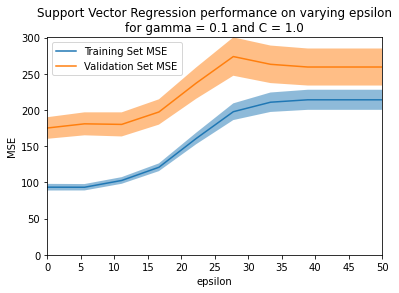

In [21]:
start_time = time.time()
svr = SVR(kernel = "rbf", cache_size=7000, gamma = svr_init_params['gamma'], C = svr_init_params['C'])
extra_string = '\nfor gamma = ' + str(svr_init_params['gamma']) + ' and C = ' + str(svr_init_params['C'])
param_grid = {"epsilon": np.linspace(0, 50, num=10)}
xticks = np.linspace(0, 50, num=11)
validation_curve('Support Vector Regression', svr, XX, YY, best_duplicates_to_keep, param_grid, False, True, extra_string, xticks)
print("Time taken: ", time.time() - start_time)

Tuning gamma

Outer Fold:  1 / 9  Complete.
Outer Fold:  2 / 9  Complete.
Outer Fold:  3 / 9  Complete.
Outer Fold:  4 / 9  Complete.
Outer Fold:  5 / 9  Complete.
Outer Fold:  6 / 9  Complete.
Outer Fold:  7 / 9  Complete.
Outer Fold:  8 / 9  Complete.
Outer Fold:  9 / 9  Complete.
Time taken:  9346.447210550308


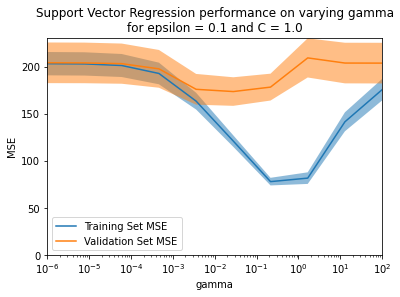

In [22]:
start_time = time.time()
svr = SVR(kernel = "rbf", cache_size=7000, epsilon = svr_init_params['epsilon'], C = svr_init_params['C'])
extra_string = '\nfor epsilon = ' + str(svr_init_params['epsilon']) + ' and C = ' + str(svr_init_params['C'])
param_grid = {"gamma": np.logspace(-6, 2, num=10)}
xticks = np.logspace(-6, 2, num=9)
validation_curve('Support Vector Regression', svr, XX, YY, best_duplicates_to_keep, param_grid, True, True, extra_string, xticks)
print("Time taken: ", time.time() - start_time)

Tuning C

Outer Fold:  1 / 9  Complete.
Outer Fold:  2 / 9  Complete.
Outer Fold:  3 / 9  Complete.
Outer Fold:  4 / 9  Complete.
Outer Fold:  5 / 9  Complete.
Outer Fold:  6 / 9  Complete.
Outer Fold:  7 / 9  Complete.
Outer Fold:  8 / 9  Complete.
Outer Fold:  9 / 9  Complete.
Time taken:  85016.52722477913


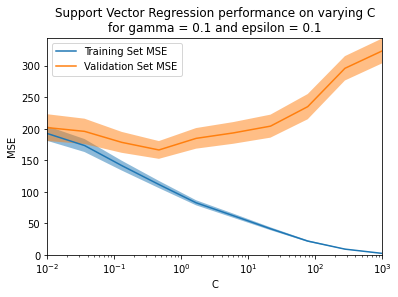

In [20]:
start_time = time.time()
svr = SVR(kernel = "rbf", cache_size=7000, gamma = svr_init_params['gamma'], epsilon = svr_init_params['epsilon'])
extra_string = '\nfor gamma = ' + str(svr_init_params['gamma']) + ' and epsilon = ' + str(svr_init_params['epsilon'])
param_grid = {"C": np.logspace(-2, 3, num=10)}
xticks = np.logspace(-2, 3, num=6)
validation_curve('Support Vector Regression', svr, XX, YY, best_duplicates_to_keep, param_grid, True, True, extra_string, xticks)
print("Time taken: ", time.time() - start_time)

Predictions VS True Values on Test Set

Outer Fold  1 / 9  completed.
Outer Fold  2 / 9  completed.
Outer Fold  3 / 9  completed.
Outer Fold  4 / 9  completed.
Outer Fold  5 / 9  completed.
Outer Fold  6 / 9  completed.
Outer Fold  7 / 9  completed.
Outer Fold  8 / 9  completed.
Outer Fold  9 / 9  completed.
Pearson Correlation Coefficient = -0.11412106666936805
Test Mean Squared Error =  221.127685323011
Train Mean Squared Error =  106.09115523193817
Time taken:  12865.010705709457


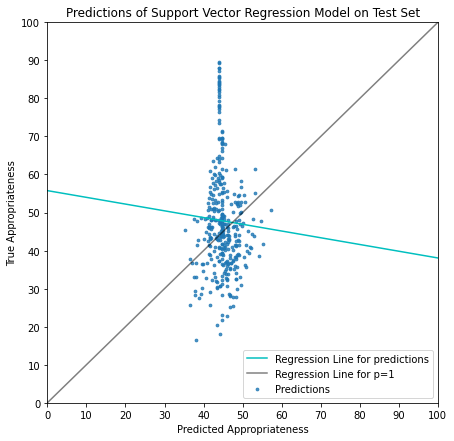

In [22]:
start_time = time.time()
svr_model = SVR(kernel = "rbf", cache_size=7000)
param_grid = {"C": np.logspace(-2, 2, num=3), "gamma": np.logspace(-3, 1, num=3), "epsilon": np.linspace(0, 30, num=3)}
predicted_vs_true('Support Vector Regression', svr_model, XX, YY, best_duplicates_to_keep, param_grid, True)
print("Time taken: ", time.time() - start_time)

# Linear Regression

Tune amount of synthesised data

Shuffle:  1 / 5  Outer Cond: 1 / 9
Shuffle:  1 / 5  Outer Cond: 2 / 9
Shuffle:  1 / 5  Outer Cond: 3 / 9
Shuffle:  1 / 5  Outer Cond: 4 / 9
Shuffle:  1 / 5  Outer Cond: 5 / 9
Shuffle:  1 / 5  Outer Cond: 6 / 9
Shuffle:  1 / 5  Outer Cond: 7 / 9
Shuffle:  1 / 5  Outer Cond: 8 / 9
Shuffle:  1 / 5  Outer Cond: 9 / 9
Shuffle:  2 / 5  Outer Cond: 1 / 9
Shuffle:  2 / 5  Outer Cond: 2 / 9
Shuffle:  2 / 5  Outer Cond: 3 / 9
Shuffle:  2 / 5  Outer Cond: 4 / 9
Shuffle:  2 / 5  Outer Cond: 5 / 9
Shuffle:  2 / 5  Outer Cond: 6 / 9
Shuffle:  2 / 5  Outer Cond: 7 / 9
Shuffle:  2 / 5  Outer Cond: 8 / 9
Shuffle:  2 / 5  Outer Cond: 9 / 9
Shuffle:  3 / 5  Outer Cond: 1 / 9
Shuffle:  3 / 5  Outer Cond: 2 / 9
Shuffle:  3 / 5  Outer Cond: 3 / 9
Shuffle:  3 / 5  Outer Cond: 4 / 9
Shuffle:  3 / 5  Outer Cond: 5 / 9
Shuffle:  3 / 5  Outer Cond: 6 / 9
Shuffle:  3 / 5  Outer Cond: 7 / 9
Shuffle:  3 / 5  Outer Cond: 8 / 9
Shuffle:  3 / 5  Outer Cond: 9 / 9
Shuffle:  4 / 5  Outer Cond: 1 / 9
Shuffle:  4 / 5  Out

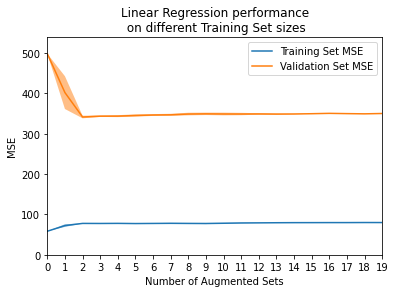

In [108]:
start_time = time.time()
best_duplicates_to_keep, best_size = learning_curve('Linear Regression', LinearRegression(), XX, YY, True)
print("Time taken: ", time.time() - start_time)

Shuffle:  1 / 5  Outer Cond: 1 / 9
Shuffle:  1 / 5  Outer Cond: 2 / 9
Shuffle:  1 / 5  Outer Cond: 3 / 9
Shuffle:  1 / 5  Outer Cond: 4 / 9
Shuffle:  1 / 5  Outer Cond: 5 / 9
Shuffle:  1 / 5  Outer Cond: 6 / 9
Shuffle:  1 / 5  Outer Cond: 7 / 9
Shuffle:  1 / 5  Outer Cond: 8 / 9
Shuffle:  1 / 5  Outer Cond: 9 / 9
Shuffle:  2 / 5  Outer Cond: 1 / 9
Shuffle:  2 / 5  Outer Cond: 2 / 9
Shuffle:  2 / 5  Outer Cond: 3 / 9
Shuffle:  2 / 5  Outer Cond: 4 / 9
Shuffle:  2 / 5  Outer Cond: 5 / 9
Shuffle:  2 / 5  Outer Cond: 6 / 9
Shuffle:  2 / 5  Outer Cond: 7 / 9
Shuffle:  2 / 5  Outer Cond: 8 / 9
Shuffle:  2 / 5  Outer Cond: 9 / 9
Shuffle:  3 / 5  Outer Cond: 1 / 9
Shuffle:  3 / 5  Outer Cond: 2 / 9
Shuffle:  3 / 5  Outer Cond: 3 / 9
Shuffle:  3 / 5  Outer Cond: 4 / 9
Shuffle:  3 / 5  Outer Cond: 5 / 9
Shuffle:  3 / 5  Outer Cond: 6 / 9
Shuffle:  3 / 5  Outer Cond: 7 / 9
Shuffle:  3 / 5  Outer Cond: 8 / 9
Shuffle:  3 / 5  Outer Cond: 9 / 9
Shuffle:  4 / 5  Outer Cond: 1 / 9
Shuffle:  4 / 5  Out

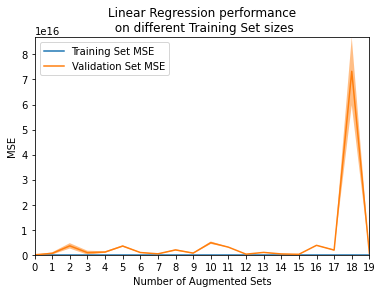

In [109]:
start_time = time.time()
best_duplicates_to_keep, best_size = learning_curve('Linear Regression', LinearRegression(), XX, YY, False)
print("Time taken: ", time.time() - start_time)

In [24]:
best_duplicates_to_keep = 2

Predicted VS True Values on Test Set

Outer Fold  1 / 9  completed.
Outer Fold  2 / 9  completed.
Outer Fold  3 / 9  completed.
Outer Fold  4 / 9  completed.
Outer Fold  5 / 9  completed.
Outer Fold  6 / 9  completed.
Outer Fold  7 / 9  completed.
Outer Fold  8 / 9  completed.
Outer Fold  9 / 9  completed.
Pearson Correlation Coefficient = 0.31257778019566385
Test Mean Squared Error =  319.5765081814334
Train Mean Squared Error =  85.30973830061028
Time taken:  21.267350435256958


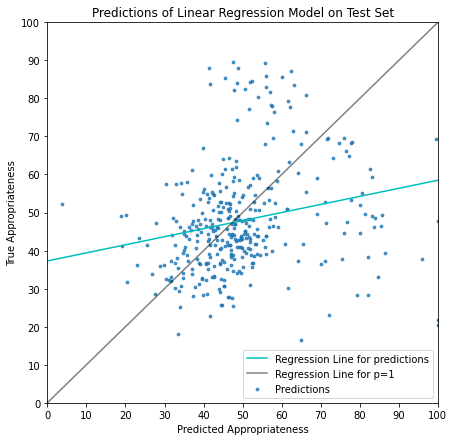

In [27]:
start_time = time.time()
predicted_vs_true('Linear Regression', LinearRegression(), XX, YY, best_duplicates_to_keep,{}, True)
print("Time taken: ", time.time() - start_time)

# Ridge Regression

Tune Dataset Size

Shuffle:  1 / 5  Outer Cond: 1 / 9
Shuffle:  1 / 5  Outer Cond: 2 / 9
Shuffle:  1 / 5  Outer Cond: 3 / 9
Shuffle:  1 / 5  Outer Cond: 4 / 9
Shuffle:  1 / 5  Outer Cond: 5 / 9
Shuffle:  1 / 5  Outer Cond: 6 / 9
Shuffle:  1 / 5  Outer Cond: 7 / 9
Shuffle:  1 / 5  Outer Cond: 8 / 9
Shuffle:  1 / 5  Outer Cond: 9 / 9
Shuffle:  2 / 5  Outer Cond: 1 / 9
Shuffle:  2 / 5  Outer Cond: 2 / 9
Shuffle:  2 / 5  Outer Cond: 3 / 9
Shuffle:  2 / 5  Outer Cond: 4 / 9
Shuffle:  2 / 5  Outer Cond: 5 / 9
Shuffle:  2 / 5  Outer Cond: 6 / 9
Shuffle:  2 / 5  Outer Cond: 7 / 9
Shuffle:  2 / 5  Outer Cond: 8 / 9
Shuffle:  2 / 5  Outer Cond: 9 / 9
Shuffle:  3 / 5  Outer Cond: 1 / 9
Shuffle:  3 / 5  Outer Cond: 2 / 9
Shuffle:  3 / 5  Outer Cond: 3 / 9
Shuffle:  3 / 5  Outer Cond: 4 / 9
Shuffle:  3 / 5  Outer Cond: 5 / 9
Shuffle:  3 / 5  Outer Cond: 6 / 9
Shuffle:  3 / 5  Outer Cond: 7 / 9
Shuffle:  3 / 5  Outer Cond: 8 / 9
Shuffle:  3 / 5  Outer Cond: 9 / 9
Shuffle:  4 / 5  Outer Cond: 1 / 9
Shuffle:  4 / 5  Out

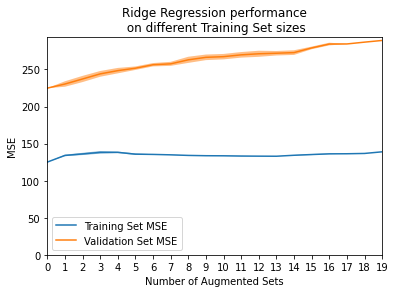

In [110]:
start_time = time.time()
param_grid = {"alpha": np.logspace(-5,15, 10)}
ridge_reg = Ridge()
# 7-fold cv with shuffle=False will hold out one cond on each fold for hyperparemter tuning inside of the learning_curve function
kfolds = KFold(n_splits = 7, shuffle = False)
ridge_model = GridSearchCV(estimator = ridge_reg, param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds) 
best_duplicates_to_keep, best_size = learning_curve('Ridge Regression', ridge_model, XX, YY, True)
print("Time taken: ", time.time() - start_time)

In [28]:
best_duplicates_to_keep = 0 # from the above learning_curves

Ridge Regression Hyperparameter Tuning

Outer Fold:  1 / 9  Complete.
Outer Fold:  2 / 9  Complete.
Outer Fold:  3 / 9  Complete.
Outer Fold:  4 / 9  Complete.
Outer Fold:  5 / 9  Complete.
Outer Fold:  6 / 9  Complete.
Outer Fold:  7 / 9  Complete.
Outer Fold:  8 / 9  Complete.
Outer Fold:  9 / 9  Complete.
Time taken:  1598.8901362419128


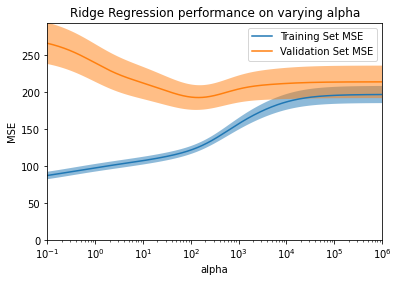

In [29]:
start_time = time.time()
xticks = np.logspace(-1,6, 8)
validation_curve('Ridge Regression', Ridge(), XX, YY, best_duplicates_to_keep, {"alpha": np.logspace(-1,6, 1000)}, True, True, '', xticks)
print("Time taken: ", time.time() - start_time)

Predicted VS True Values on Test Set

Outer Fold  1 / 9  completed.
Outer Fold  2 / 9  completed.
Outer Fold  3 / 9  completed.
Outer Fold  4 / 9  completed.
Outer Fold  5 / 9  completed.
Outer Fold  6 / 9  completed.
Outer Fold  7 / 9  completed.
Outer Fold  8 / 9  completed.
Outer Fold  9 / 9  completed.
Pearson Correlation Coefficient = -0.17064729270131535
Test Mean Squared Error =  271.13445408572676
Train Mean Squared Error =  127.63605317059782
Time taken:  481.51885437965393


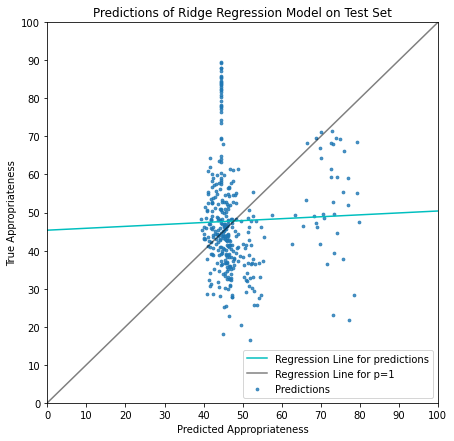

In [30]:
start_time = time.time()
param_grid = {"alpha": np.logspace(-1,6, 1000)}
ridge_model = Ridge()
predicted_vs_true('Ridge Regression', ridge_model, XX, YY, best_duplicates_to_keep, param_grid, True)
print("Time taken: ", time.time() - start_time)

# Kernel Ridge Regression

Tuning Dataset Size

Shuffle:  1 / 5  Outer Cond: 1 / 9
Shuffle:  1 / 5  Outer Cond: 2 / 9
Shuffle:  1 / 5  Outer Cond: 3 / 9
Shuffle:  1 / 5  Outer Cond: 4 / 9
Shuffle:  1 / 5  Outer Cond: 5 / 9
Shuffle:  1 / 5  Outer Cond: 6 / 9
Shuffle:  1 / 5  Outer Cond: 7 / 9
Shuffle:  1 / 5  Outer Cond: 8 / 9
Shuffle:  1 / 5  Outer Cond: 9 / 9
Shuffle:  2 / 5  Outer Cond: 1 / 9
Shuffle:  2 / 5  Outer Cond: 2 / 9
Shuffle:  2 / 5  Outer Cond: 3 / 9
Shuffle:  2 / 5  Outer Cond: 4 / 9
Shuffle:  2 / 5  Outer Cond: 5 / 9
Shuffle:  2 / 5  Outer Cond: 6 / 9
Shuffle:  2 / 5  Outer Cond: 7 / 9
Shuffle:  2 / 5  Outer Cond: 8 / 9
Shuffle:  2 / 5  Outer Cond: 9 / 9
Shuffle:  3 / 5  Outer Cond: 1 / 9
Shuffle:  3 / 5  Outer Cond: 2 / 9
Shuffle:  3 / 5  Outer Cond: 3 / 9
Shuffle:  3 / 5  Outer Cond: 4 / 9
Shuffle:  3 / 5  Outer Cond: 5 / 9
Shuffle:  3 / 5  Outer Cond: 6 / 9
Shuffle:  3 / 5  Outer Cond: 7 / 9
Shuffle:  3 / 5  Outer Cond: 8 / 9
Shuffle:  3 / 5  Outer Cond: 9 / 9
Shuffle:  4 / 5  Outer Cond: 1 / 9
Shuffle:  4 / 5  Out

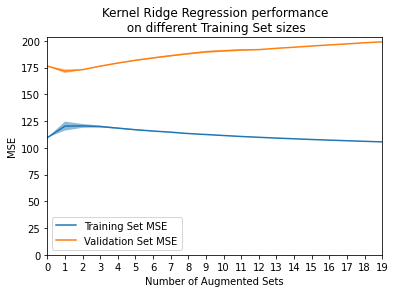

In [111]:
start_time = time.time()
krr = KernelRidge(kernel = "rbf")
# No hyperparameter tuning since it would take far too long
best_duplicates_to_keep, best_size = learning_curve('Kernel Ridge Regression', krr, XX, YY, True)
print("Time taken: ", time.time() - start_time)

In [19]:
best_duplicates_to_keep = 1 # from the above learning curves

Grid Search Cross Validation for Inititalization with Hyperparameter Tuning

In [20]:
start_time = time.time()
modified_XX, modified_YY = reduce_dataset_size(XX, YY, get_rand_studyseqs(best_duplicates_to_keep))
modified_XX_train, modified_YY_train, modified_XX_test, modified_YY_test = split_by_cond(modified_XX, modified_YY, 'Cond_SE')
modified_XX_train, modified_YY_train = modified_XX_train.iloc[:,2:], modified_YY_train.iloc[:,2:] # drop cond and studyseq columns
modified_YY_train = modified_YY_train.values.flatten()

param_grid = {"alpha": np.logspace(-10,10, 11), "gamma": np.logspace(-10, 10, 11)}
# 8 fold with shuffle=False holds one cond out on each inner fold of the predicted_vs_true function
kfolds = KFold(n_splits = 8, shuffle = False)
krr = GridSearchCV(estimator = KernelRidge(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error", cv=kfolds)
krr.fit(modified_XX_train, modified_YY_train)

krr_init_params = krr.best_params_
print("Time taken: ", time.time() - start_time)

Time taken:  28.43774151802063


Tuning Alpha

Outer Fold:  1 / 9  Complete.
Outer Fold:  2 / 9  Complete.
Outer Fold:  3 / 9  Complete.
Outer Fold:  4 / 9  Complete.
Outer Fold:  5 / 9  Complete.
Outer Fold:  6 / 9  Complete.
Outer Fold:  7 / 9  Complete.
Outer Fold:  8 / 9  Complete.
Outer Fold:  9 / 9  Complete.
Time taken:  563.8837893009186


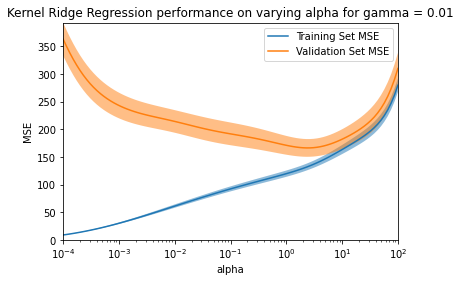

In [21]:
start_time = time.time()
krr = KernelRidge(kernel = "rbf", gamma = krr_init_params['gamma'])
extra_string = ' for gamma = ' + str(krr_init_params['gamma'])
param_grid = {"alpha": np.logspace(-4, 2, 100)}
xticks = np.logspace(-4, 2, 7)
validation_curve('Kernel Ridge Regression', krr, XX, YY, best_duplicates_to_keep, param_grid, True, True, extra_string, xticks)
print("Time taken: ", time.time() - start_time)

Tuning Gamma

Outer Fold:  1 / 9  Complete.
Outer Fold:  2 / 9  Complete.
Outer Fold:  3 / 9  Complete.
Outer Fold:  4 / 9  Complete.
Outer Fold:  5 / 9  Complete.
Outer Fold:  6 / 9  Complete.
Outer Fold:  7 / 9  Complete.
Outer Fold:  8 / 9  Complete.
Outer Fold:  9 / 9  Complete.
Time taken:  613.8803353309631


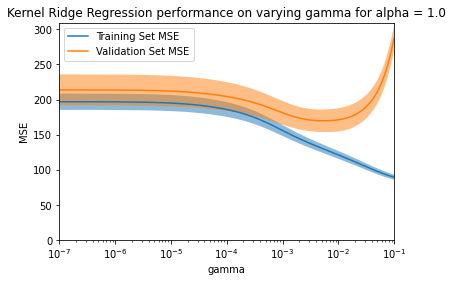

In [22]:
start_time = time.time()
krr = KernelRidge(kernel = "rbf", alpha = krr_init_params['alpha'])
extra_string = ' for alpha = ' + str(krr_init_params['alpha'])
param_grid = {"gamma": np.logspace(-7, -1, 100)}
xticks = np.logspace(-7, -1, 7)
validation_curve('Kernel Ridge Regression', krr, XX, YY, best_duplicates_to_keep, param_grid, True, True, extra_string, xticks)
print("Time taken: ", time.time() - start_time)

Graph of Predicted VS True Values on Test Set

Outer Fold  1 / 9  completed.
Outer Fold  2 / 9  completed.
Outer Fold  3 / 9  completed.
Outer Fold  4 / 9  completed.
Outer Fold  5 / 9  completed.
Outer Fold  6 / 9  completed.
Outer Fold  7 / 9  completed.
Outer Fold  8 / 9  completed.
Outer Fold  9 / 9  completed.
Pearson Correlation Coefficient = 0.3451962391397686
Test Mean Squared Error =  166.8114842261057
Train Mean Squared Error =  131.93061153627724
Time taken:  3713.7887382507324


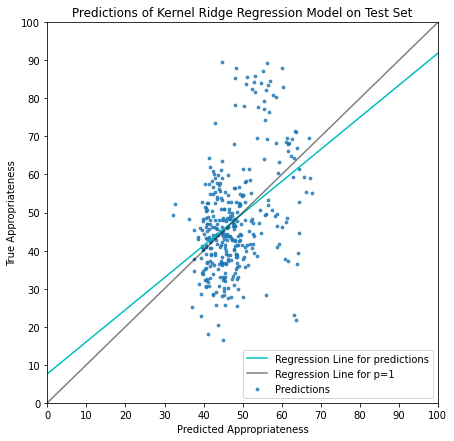

In [23]:
start_time = time.time()
krr_model = KernelRidge(kernel = "rbf")
param_grid = {"alpha": np.logspace(-4, 2, 50), "gamma": np.logspace(-7, -1, 50)}
predicted_vs_true('Kernel Ridge Regression', krr_model, XX, YY, best_duplicates_to_keep, param_grid, True)
print("Time taken: ", time.time() - start_time)

# kNN Regression

Tune Dataset Size

Shuffle:  1 / 5  Outer Cond: 1 / 9
Shuffle:  1 / 5  Outer Cond: 2 / 9
Shuffle:  1 / 5  Outer Cond: 3 / 9
Shuffle:  1 / 5  Outer Cond: 4 / 9
Shuffle:  1 / 5  Outer Cond: 5 / 9
Shuffle:  1 / 5  Outer Cond: 6 / 9
Shuffle:  1 / 5  Outer Cond: 7 / 9
Shuffle:  1 / 5  Outer Cond: 8 / 9
Shuffle:  1 / 5  Outer Cond: 9 / 9
Shuffle:  2 / 5  Outer Cond: 1 / 9
Shuffle:  2 / 5  Outer Cond: 2 / 9
Shuffle:  2 / 5  Outer Cond: 3 / 9
Shuffle:  2 / 5  Outer Cond: 4 / 9
Shuffle:  2 / 5  Outer Cond: 5 / 9
Shuffle:  2 / 5  Outer Cond: 6 / 9
Shuffle:  2 / 5  Outer Cond: 7 / 9
Shuffle:  2 / 5  Outer Cond: 8 / 9
Shuffle:  2 / 5  Outer Cond: 9 / 9
Shuffle:  3 / 5  Outer Cond: 1 / 9
Shuffle:  3 / 5  Outer Cond: 2 / 9
Shuffle:  3 / 5  Outer Cond: 3 / 9
Shuffle:  3 / 5  Outer Cond: 4 / 9
Shuffle:  3 / 5  Outer Cond: 5 / 9
Shuffle:  3 / 5  Outer Cond: 6 / 9
Shuffle:  3 / 5  Outer Cond: 7 / 9
Shuffle:  3 / 5  Outer Cond: 8 / 9
Shuffle:  3 / 5  Outer Cond: 9 / 9
Shuffle:  4 / 5  Outer Cond: 1 / 9
Shuffle:  4 / 5  Out

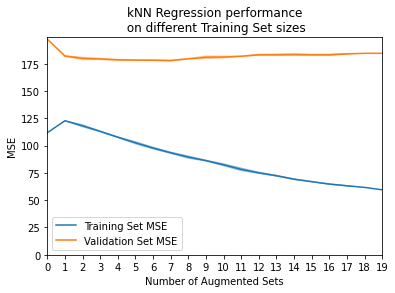

In [112]:
start_time = time.time()
# 7-fold cv with shuffle=False will hold out one cond on each fold for hyperparemter tuning inside of the learning_curve function
kfolds = KFold(n_splits = 7, shuffle = False)
param_grid = {"n_neighbors": np.arange(1,41,5)}
knn = KNeighborsRegressor()
knn_model = GridSearchCV(estimator = knn, param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
best_duplicates_to_keep, best_size = learning_curve('kNN Regression', knn_model, XX, YY, True)
print("Time taken: ", time.time() - start_time)

In [24]:
best_duplicates_to_keep = 7

Tune n_neighbors for weights = uniform

Outer Fold:  1 / 9  Complete.
Outer Fold:  2 / 9  Complete.
Outer Fold:  3 / 9  Complete.
Outer Fold:  4 / 9  Complete.
Outer Fold:  5 / 9  Complete.
Outer Fold:  6 / 9  Complete.
Outer Fold:  7 / 9  Complete.
Outer Fold:  8 / 9  Complete.
Outer Fold:  9 / 9  Complete.
Time taken:  957.4599561691284


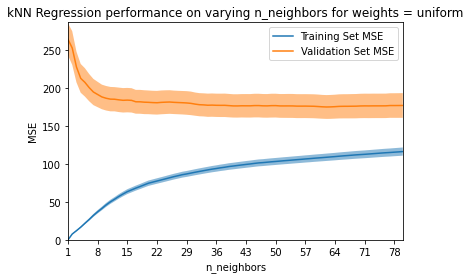

In [25]:
start_time = time.time()
knn = KNeighborsRegressor(weights = 'uniform')
extra_string = ' for weights = uniform'
param_grid = {"n_neighbors": np.arange(1,81,1)}
xticks = np.arange(1,81,7)
validation_curve('kNN Regression', knn, XX, YY, best_duplicates_to_keep, param_grid, False, True, extra_string, xticks)
print("Time taken: ", time.time() - start_time)

Tune n_neighbors for weights = distance

Outer Fold:  1 / 9  Complete.
Outer Fold:  2 / 9  Complete.
Outer Fold:  3 / 9  Complete.
Outer Fold:  4 / 9  Complete.
Outer Fold:  5 / 9  Complete.
Outer Fold:  6 / 9  Complete.
Outer Fold:  7 / 9  Complete.
Outer Fold:  8 / 9  Complete.
Outer Fold:  9 / 9  Complete.
Time taken:  922.6542439460754


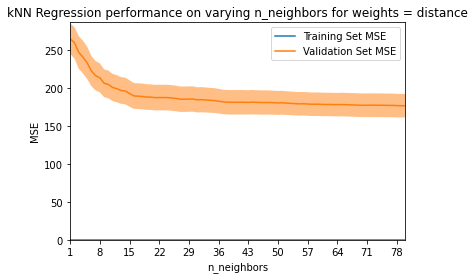

In [26]:
start_time = time.time()
knn = KNeighborsRegressor(weights = 'distance')
extra_string = ' for weights = distance'
param_grid = {"n_neighbors": np.arange(1,81,1)}
xticks = np.arange(1,81,7)
validation_curve('kNN Regression', knn, XX, YY, best_duplicates_to_keep, param_grid, False, True, extra_string, xticks)
print("Time taken: ", time.time() - start_time)

Predicted VS True

Outer Fold  1 / 9  completed.
Outer Fold  2 / 9  completed.
Outer Fold  3 / 9  completed.
Outer Fold  4 / 9  completed.
Outer Fold  5 / 9  completed.
Outer Fold  6 / 9  completed.
Outer Fold  7 / 9  completed.
Outer Fold  8 / 9  completed.
Outer Fold  9 / 9  completed.
Pearson Correlation Coefficient = 0.170563958655313
Test Mean Squared Error =  193.40429535091982
Train Mean Squared Error =  63.11881463795754
Time taken:  155.9659333229065


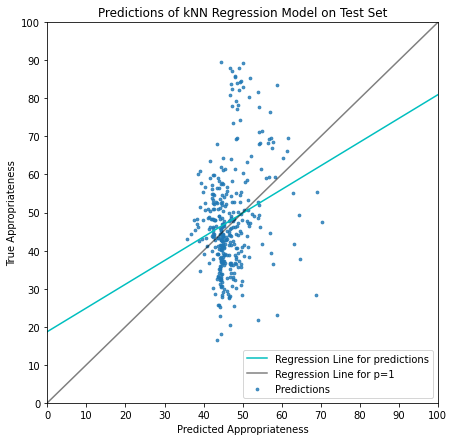

In [27]:
start_time = time.time()
param_grid = {"n_neighbors": np.arange(1,81,1), "weights": ["uniform", "distance"]}
knn_model = KNeighborsRegressor()
predicted_vs_true('kNN Regression', knn_model, XX, YY, best_duplicates_to_keep, param_grid, True)
print("Time taken: ", time.time() - start_time)

# Train vs Test MSEs

In [ ]:
# SVR
print("SVR Train MSE: ", mean_squared_error(YY_train, svr.best_estimator_.predict(XX_train)))
print("SVR Test MSE: ", mean_squared_error(YY_test, svr.best_estimator_.predict(XX_test)))

# Linear Regression
print("Linear Regression Train MSE: ", mean_squared_error(YY_train,lr.predict(XX_train)))
print("Linear Regression Test MSE: ", mean_squared_error(YY_test, lr.predict(XX_test)))

# Ridge Regression
print("Ridge Regression Train MSE: ", mean_squared_error(YY_train, ridge_model.best_estimator_.predict(XX_train)))
print("Ridge Regression Test MSE: ", mean_squared_error(YY_test, ridge_model.best_estimator_.predict(XX_test)))

# Kernel Ridge Regression
print("Kernel Ridge Regression Train MSE: ", mean_squared_error(YY_train, krr_model.best_estimator_.predict(XX_train)))
print("Kernel Ridge Regression Test MSE: ", mean_squared_error(YY_test, krr_model.best_estimator_.predict(XX_test)))

# kNN Regression
print("KNN Regression Train MSE: ", mean_squared_error(YY_train, knn_model.best_estimator_.predict(XX_train)))
print("KNN Regression Test MSE: ", mean_squared_error(YY_test, knn_model.best_estimator_.predict(XX_test)))

In [ ]:
knn_model.best_params_